# Scott Breitbach
## Project 2: Stroke Prediction
## DSC680, Weeks 5-7
## 10-July-2022

In [ ]:
## Load Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# plotting:
import matplotlib.pyplot as plt
import seaborn as sns
# encoding categorical variables
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
# data transformations
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
# balancing data
from imblearn.over_sampling import RandomOverSampler

# Load Data

In [ ]:
# import files to colab
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train_strokes.csv to train_strokes.csv
User uploaded file "train_strokes.csv" with length 2635787 bytes


In [ ]:
def load_dataframe(path):
  # load dataset as pandas DataFrame
  DF = pd.read_csv(path, index_col=0)
  return DF

# load the dataframe
strokeDF = load_dataframe('/content/train_strokes.csv')

# Look at data

In [ ]:
# look at dataframe
strokeDF.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [ ]:
# display object types
strokeDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43400 entries, 30669 to 36271
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             43400 non-null  object 
 1   age                43400 non-null  float64
 2   hypertension       43400 non-null  int64  
 3   heart_disease      43400 non-null  int64  
 4   ever_married       43400 non-null  object 
 5   work_type          43400 non-null  object 
 6   Residence_type     43400 non-null  object 
 7   avg_glucose_level  43400 non-null  float64
 8   bmi                41938 non-null  float64
 9   smoking_status     30108 non-null  object 
 10  stroke             43400 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 4.0+ MB


In [ ]:
# summarize numerical data
strokeDF.describe().T

,count,mean,std,min,25%,50%,75%,max
age,43400.0,42.217894,22.519649,0.08,24.00,44.00,60.00,82.00
hypertension,43400.0,0.093571,0.291235,0.00,0.00,0.00,0.00,1.00
heart_disease,43400.0,0.047512,0.212733,0.00,0.00,0.00,0.00,1.00
avg_glucose_level,43400.0,104.482750,43.111751,55.00,77.54,91.58,112.07,291.05
bmi,41938.0,28.605038,7.770020,10.10,23.20,27.70,32.90,97.60
stroke,43400.0,0.018041,0.133103,0.00,0.00,0.00,0.00,1.00


* Minimum `age` of 0.08 years (1 month) is unlikely to be correct. Will need to look at distribution and establish a cutoff.

* `hypertension` and `heart_disease` appear to already be scaled 0-1, which is probably fine.

* `avg_glucose_level` Note: "A blood sugar level less than 140 mg/dL (7.8 mmol/L) is normal. A reading of more than 200 mg/dL (11.1 mmol/L) after two hours indicates diabetes. A reading between 140 and 199 mg/dL (7.8 mmol/L and 11.0 mmol/L) indicates prediabetes." per [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451)

* A minimum `bmi` of [10.10 is not entirely unreasonable](https://www.ennonline.net/fex/15/limits).

In [ ]:
# summarize categorical data
strokeDF.describe(exclude=['float', 'int']).T

,count,unique,top,freq
gender,43400,3,Female,25665
ever_married,43400,2,Yes,27938
work_type,43400,5,Private,24834
Residence_type,43400,2,Urban,21756
smoking_status,30108,3,never smoked,16053


In [ ]:
# show categories for each categorical column
for i in strokeDF.columns:
  if strokeDF[i].dtype == 'O':
    print(f'\n* {i}:')
    print(strokeDF[i].value_counts())


* gender:
Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

* ever_married:
Yes    27938
No     15462
Name: ever_married, dtype: int64

* work_type:
Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: work_type, dtype: int64

* Residence_type:
Urban    21756
Rural    21644
Name: Residence_type, dtype: int64

* smoking_status:
never smoked       16053
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64


In [ ]:
# Count null values in each column
strokeDF.isna().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [ ]:
# how much of the data is Null
num = round(strokeDF.bmi.isna().sum() / len(strokeDF) * 100, 1)
print(f'{num}% of bmi data is Null')

num = round(strokeDF.smoking_status.isna().sum() / len(strokeDF) * 100, 1)
print(f'{num}% of smoking_status data is Null')

3.4% of bmi data is Null
30.6% of smoking_status data is Null


# Clean data

## Impute Null values in `smoking_status` to 'unknown'

In [ ]:
# impute null smoking values to class 'unknown'
strokeDF['smoking_status'] = strokeDF['smoking_status'].fillna('unknown')
# confirm imputation
strokeDF.smoking_status.value_counts()

never smoked       16053
unknown            13292
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64

## Convert `smoking_status` categories to single word descriptors

In [ ]:
# swap out to simpler smoking descriptions
strokeDF['smoking_status'].replace(['never smoked', 'formerly smoked', 'smokes'],
                                   ['never', 'former', 'smoker'], inplace=True)

# Look at distributions

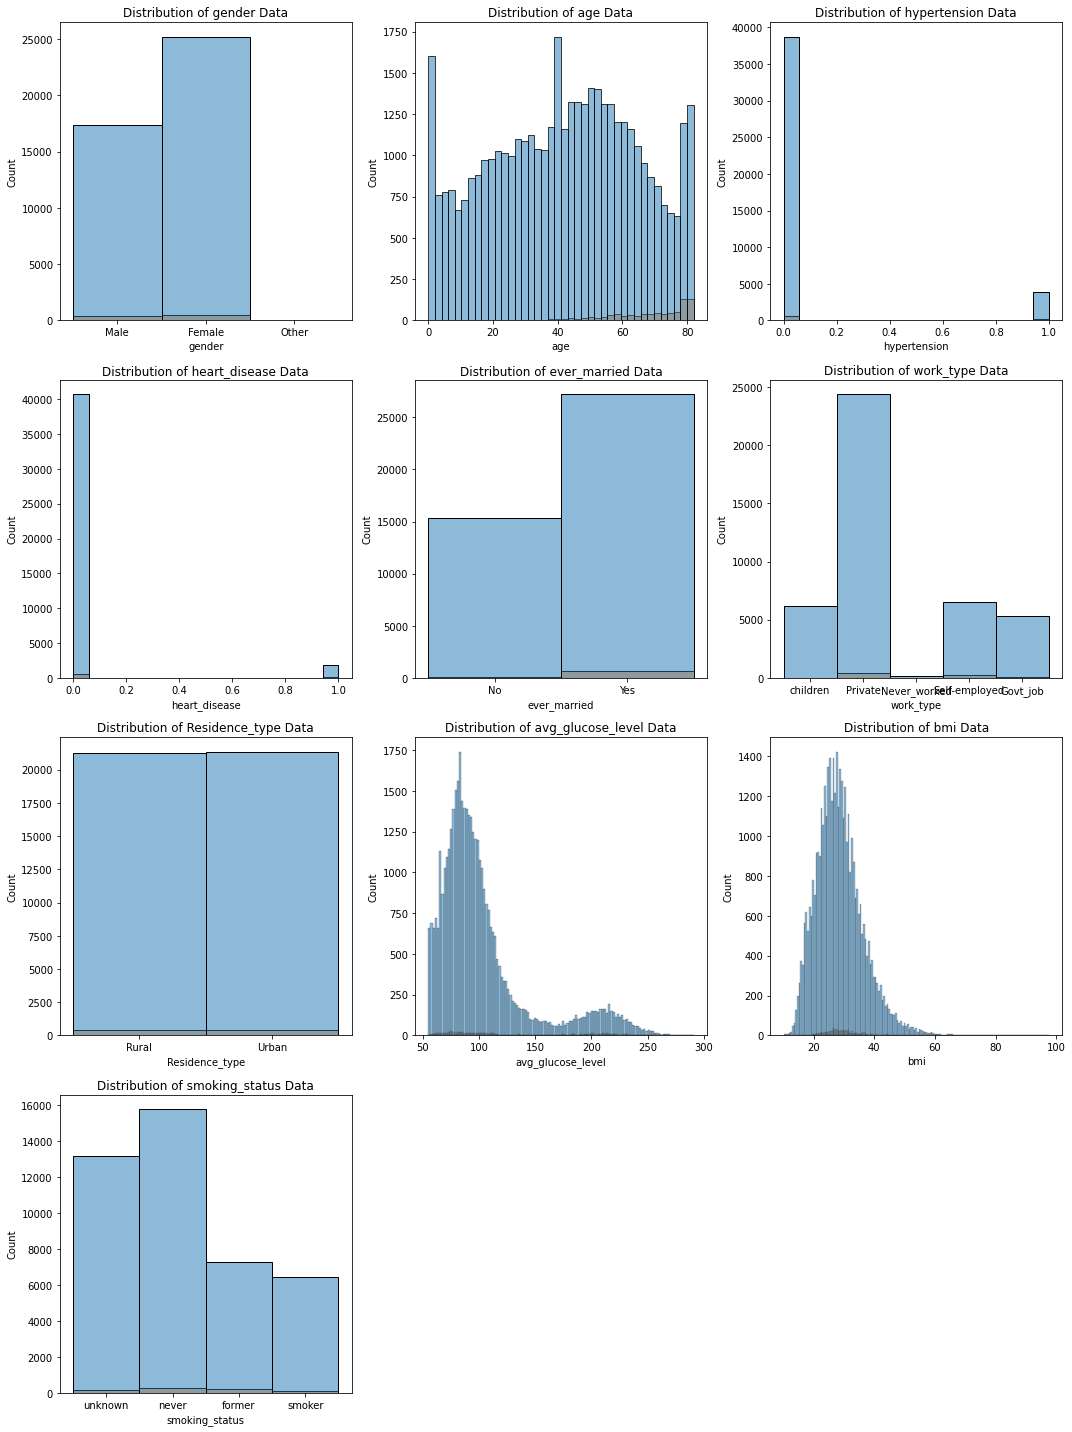

CPU times: user 8.41 s, sys: 237 ms, total: 8.65 s
Wall time: 9.44 s


In [ ]:
%%time
# Look at histograms by variable
plt.figure(figsize=(15, 20))
for i, col in enumerate(strokeDF.columns[:-1], 1):
  plt.subplot(4, 3, i)
  plt.title(f'Distribution of {col} Data')
  sns.histplot(data=strokeDF, x=col, kde=False, hue='stroke', legend=False)
  plt.tight_layout()
  plt.plot()
plt.show()

### Things to fix:
* Remove 'Other' gender (only 11)? Maybe not, idk. Could simplfy to 1 column
* Fix 'age' outliers? Seems too many near 0; huge jump around 80?
* 'avg_glucose_level' and 'bmi' are skewed
* Huge imbalance in target variable 'stroke' (difficult to compare stroke vs non-stroke distributions). Balance training data

## Compare distributions with balanced dataset

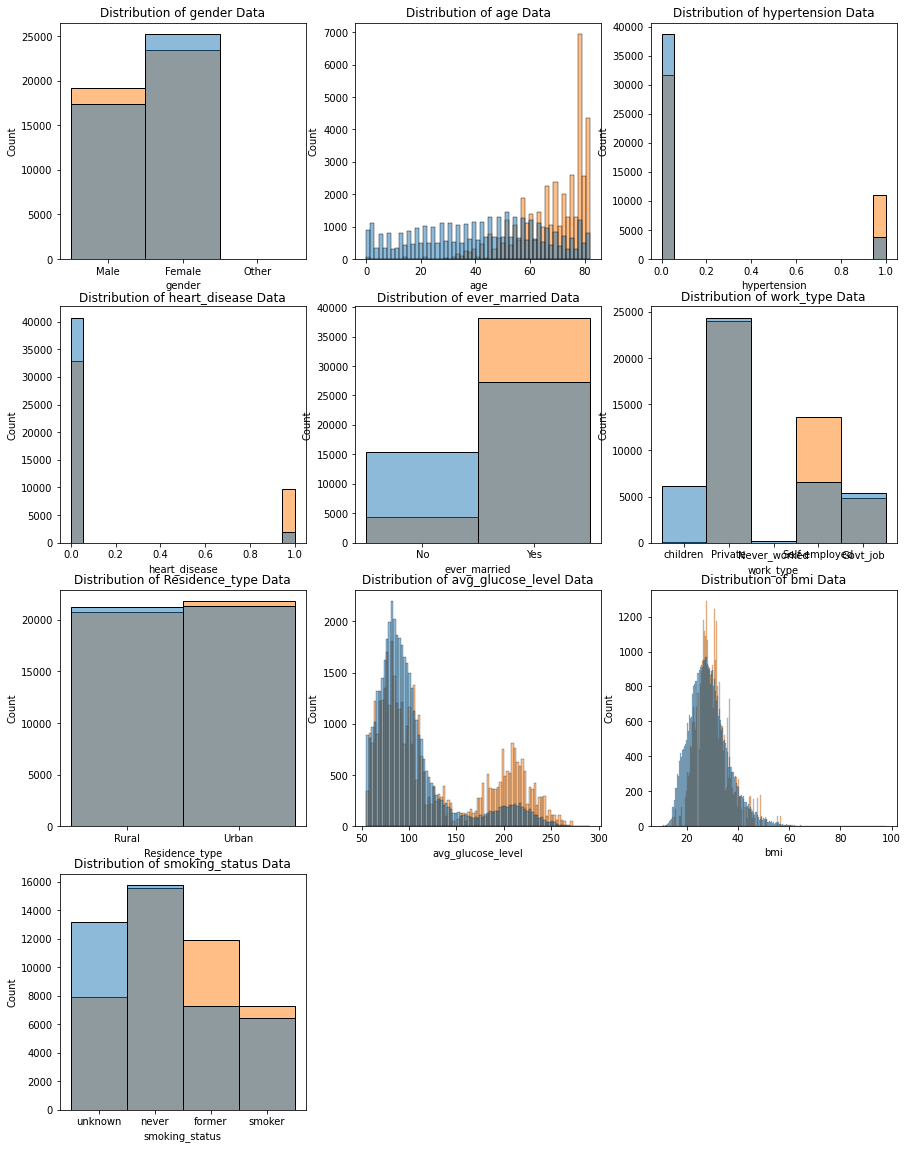

In [ ]:
## BALANCE BASED ON TARGET (STROKE)
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
# fit and apply the transform
y = strokeDF.stroke
X, y = oversample.fit_resample(strokeDF, y)


# Look at histograms by variable
plt.figure(figsize=(15, 20))
for i, col in enumerate(X.columns[:-1], 1):
  plt.subplot(4, 3, i)
  plt.title(f'Distribution of {col} Data')
  sns.histplot(data=X, x=col, kde=False, hue='stroke', legend=False)
  plt.plot()
plt.show()

### Feature Considerations:
* `work_status` 'Self_employed' shows higher stroke risk (and lower stroke risk for being a child). Possibly convert to 2 categories: self-employed vs other?  
* Very little difference in `Residence_type`. Remove feature?  
* `smoking_status`: stroke risk increased with smoking; combine smoker & former smoker and make 2 categories: smoke vs other?
* Very few young people are at risk for stroke (4 cases under age 30). Consider only using data from `age` > 30?

In [ ]:
# look at stroke cases for < age 30
strokeDF[strokeDF.stroke == 1][strokeDF.age < 30]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,unknown,1
49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,unknown,1
71866,Male,21.00,0,0,No,Private,Rural,67.42,25.7,never,1
38112,Male,29.00,0,0,Yes,Private,Rural,60.72,NaN,former,1


Keep all data for now. Eliminate features later if it seems prudent.

## Impute Null values in `bmi` using median
Note: compared imputation with mean, median, and using logistic regression. All were relatively the same, but median generally performed best for most models (and is much simpler than regression).  
Note: while the right thing to do would be to impute using the median of the training data, there is very little difference overall when imputing with different values and median is unlikely to vary by much between overall and training datasets.

In [ ]:
# impute missing 'bmi' values with median
strokeDF.bmi.fillna(strokeDF.bmi.median(), inplace=True)

In [ ]:
# confirm no null values remaining
strokeDF.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# Encode categorical variables

Okay, none of the 'Other' gender had a stroke and it's only 0.03% of the dataset, so I'm going to remove those 11 in the interest of simplifying and reducing overall complexity. Maybe this is an ethical concern to consider.

In [ ]:
# make a copy of the data to go back to if needed
DF = strokeDF[strokeDF['gender'] != 'Other'].copy()

In [ ]:
## ENCODE BINARY VALUES
# encode Yes/No to 1/0
DF.ever_married.replace(['Yes', 'No'], [1, 0], inplace=True)
# encode gender to 1/0
DF.gender.replace(['Male', 'Female'], [1, 0], inplace=True)
# encode Urban/Rural to 1/0
DF.Residence_type.replace(['Rural', 'Urban'], [1, 0], inplace=True)

In [ ]:
## ONE HOT ENCODE CATEGORICAL VALUES
# one hot encode remaining categorical variables
transformer = make_column_transformer(
    (OneHotEncoder(), ['work_type', 'smoking_status']), 
    remainder='passthrough')
transformed = transformer.fit_transform(DF)
DF = pd.DataFrame(transformed, columns=transformer.get_feature_names_out(), 
                  index=DF.index) # fix index that was reset

# remove prefixes added by OneHotEncoder()
DF.columns = DF.columns.str.replace("onehotencoder__", "")
DF.columns = DF.columns.str.replace("remainder__", "")

# Train Test Split

In [ ]:
## SEPARATE DATA FROM TARGET
X, y = DF.iloc[:,:-1], DF.iloc[:,-1]

## SPLIT TRAINING AND TEST SETS
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.33, random_state=42, 
  stratify=y) # stratify to maintain proportion of target variable

# Data transformation

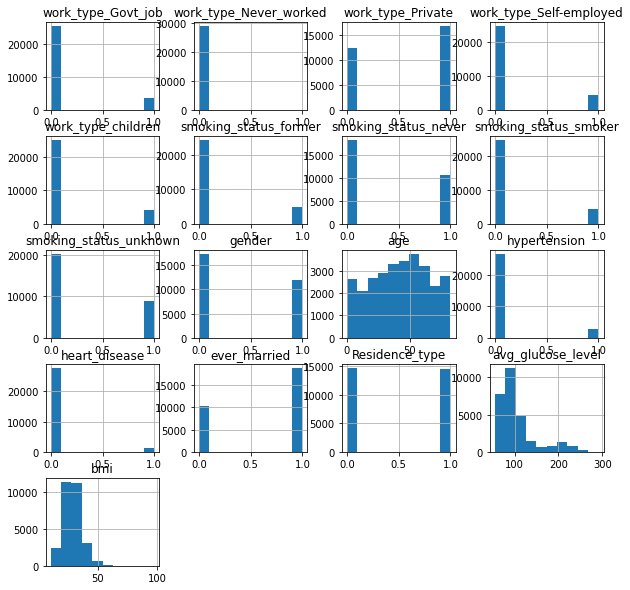

In [ ]:
# Look at distributions pre-transformation
X_train.hist(figsize=(10,10))
plt.show()

In [ ]:
## TRANSFORM FEATURES
# define the pipeline 
# (yes, I know a pipeline isn't needed for a single transformation)
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('p', power)])

# specify columns to box-cox transform
cols_to_transform = ['age', 'avg_glucose_level', 'bmi']
# transform features and apply to both train and test sets
for i in cols_to_transform:
  X_train[i] = pipeline.fit_transform(X_train[i].values.reshape(-1,1))
  X_test[i] = pipeline.transform(X_test[i].values.reshape(-1,1))

# scale entire dataset to the same range
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

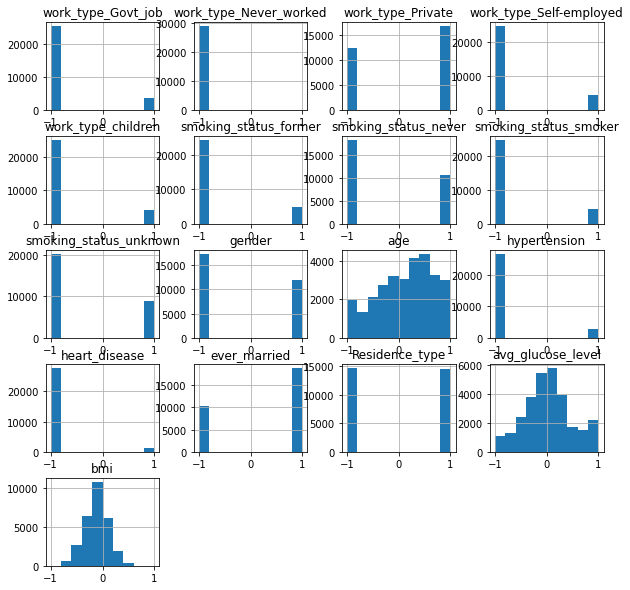

In [ ]:
# Look at distributions post-transformation
dataset = pd.DataFrame(X_train, columns=DF.columns[:-1])
dataset.hist(figsize=(10,10))
plt.show()

# Balance Training dataset

In [ ]:
  ## BALANCE BASED ON TARGET (STROKE)
  # define oversampling strategy
  oversample = RandomOverSampler(#sampling_strategy='minority', 
                                 sampling_strategy=0.5,
                                 random_state=42)
  # fit and apply the transform
  X_over, y_over = oversample.fit_resample(X_train, y_train)

## Try balancing using SMOTE

In [ ]:
import imblearn
from collections import Counter

# summarize class distribution
counter = Counter(y_train)
print(counter)

Counter({0.0: 28545, 1.0: 525})


In [ ]:
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE(sampling_strategy=0.5,
                   random_state=42)

X_smote, y_smote = oversample.fit_resample(X_train, y_train)

# summarize class distribution
counter = Counter(y_smote)
print(counter)

Counter({0.0: 28545, 1.0: 14272})


## Oversample SMOTE, then undersample

In [ ]:
from pandas.core.common import random_state
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


over = SMOTE(sampling_strategy=0.1,
             random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5,
                           random_state=42)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_ou_smote, y_ou_smote = pipeline.fit_resample(X_train, y_train)

# [Compare Classification Methods](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
Oversampled positive stroke

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score, f1_score

# Set up DataFrame to store comparisons
model_compare = pd.DataFrame()

def get_model_metrics(name, model):
  '''Prints confusion matrix and some metrics; returns metrics in a DF'''
  cols = ['Model', 'Accuracy', 'Bal Acc', 'F1_Score', 'F1 Weighted', 'Precision', 'Recall', 'MCC']# 
    # get predictions
  predictions = model.predict(X_test)
  
  # print confusion matrix
  cm = confusion_matrix(y_test, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=model.classes_)
  print(cm)
  disp.plot()
  plt.show()  
  
  # get accuracy, f1-score, precision, and recall
  # accuracy = round(model.score(X_test, y_test)*100, 2)
  # # balanced accuracy
  # bal_acc = round(balanced_accuracy_score(y_test, predictions, adjusted=True)*100, 2)  
  cr = classification_report(y_test, predictions, output_dict=True)
  accuracy = round(cr['accuracy']*100, 2)
  print('Accuracy: ', accuracy)
  f1Score = round(cr['1.0']['f1-score'], 4)
  print('F1-Score: ', f1Score)
  # # weighted f1 score
  # f1Weight = round(f1_score(y_test, predictions, average='weighted'), 4)  
  precision = round(cr['1.0']['precision'], 4)
  print('Precision:', precision)
  recall = round(cr['1.0']['recall'], 4)
  print('Recall:   ', recall)
  MCC = round(matthews_corrcoef(y_test, predictions), 4)
  print('MCC:      ', MCC)

  df = pd.DataFrame([[name, accuracy, bal_acc, f1Score, f1Weight, precision, recall, MCC]],# 
                    columns=cols)
  return df

## Random Forest

In [ ]:
%%time
# Load libraries
from sklearn.ensemble import RandomForestClassifier

# Create classifier
rfClass = RandomForestClassifier(class_weight='balanced')

# Train model
rfClass.fit(X_over, y_over)

CPU times: user 3.41 s, sys: 51.6 ms, total: 3.46 s
Wall time: 3.44 s


[[14023    38]
 [  255     3]]


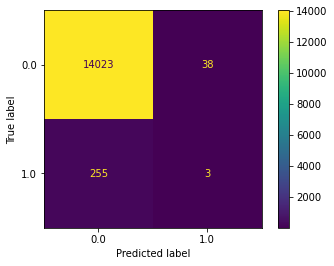

Accuracy:  97.95
F1-Score:  0.0201
Precision: 0.0732
Recall:    0.0116
MCC:       0.0222


In [ ]:
# Evaluate model
tempDF = get_model_metrics('RandomForest', rfClass)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Decision Tree

In [ ]:
%%time
# Load libraries
from sklearn.tree import DecisionTreeClassifier

# Create decision tree regressor object
decisiontree = DecisionTreeClassifier(class_weight='balanced')

# Train model
decisiontree.fit(X_over, y_over)

CPU times: user 159 ms, sys: 3.87 ms, total: 162 ms
Wall time: 159 ms


[[13821   240]
 [  239    19]]


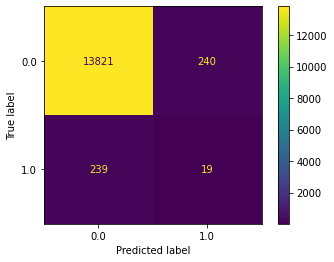

Accuracy:  96.65
F1-Score:  0.0735
Precision: 0.0734
Recall:    0.0736
MCC:       0.0565


In [ ]:
# Evaluate model
tempDF = get_model_metrics('DecisionTree', decisiontree)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Logistic Regression

In [ ]:
%%time
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create logistic regression
logit = LogisticRegression(class_weight='balanced')

# Train model
logit.fit(X_over, y_over)

CPU times: user 1.03 s, sys: 607 ms, total: 1.63 s
Wall time: 870 ms


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[10385  3676]
 [   47   211]]


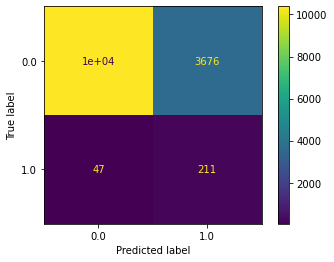

Accuracy:  74.0
F1-Score:  0.1018
Precision: 0.0543
Recall:    0.8178
MCC:       0.1664


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LogReg', logit)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

In [ ]:
%%time
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create logistic regression
logit = LogisticRegression(class_weight='balanced',
                           solver='liblinear')

# Train model
logit.fit(X_over, y_over)

CPU times: user 367 ms, sys: 6.9 ms, total: 374 ms
Wall time: 371 ms


[[11884  2177]
 [   88   170]]


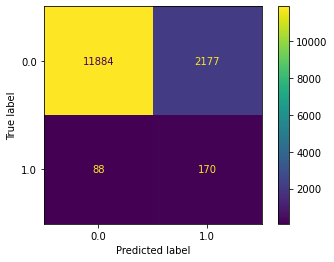

Accuracy:  84.18
F1-Score:  0.1305
Precision: 0.0724
Recall:    0.6589
MCC:       0.1811


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LogReg', logit)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Gaussian Naive Bayes Classifier

In [ ]:
%%time
# Load libraries
from sklearn.naive_bayes import GaussianNB

# Create Gaussian naive Bayes object
nBayes = GaussianNB()

# Fit model
nBayes.fit(X_over, y_over)

CPU times: user 26.5 ms, sys: 960 µs, total: 27.5 ms
Wall time: 27.2 ms


[[ 2186 11875]
 [    2   256]]


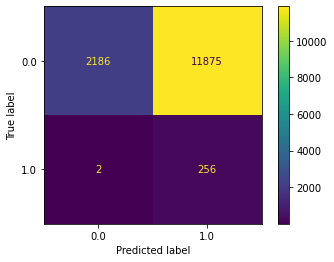

Accuracy:  17.05
F1-Score:  0.0413
Precision: 0.0211
Recall:    0.9922
MCC:       0.0546


In [ ]:
# Evaluate model
tempDF = get_model_metrics('GaussianNB', nBayes)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

In [ ]:
%%time
# Load libraries
from sklearn.naive_bayes import BernoulliNB

# Create Gaussian naive Bayes object
nBayes = BernoulliNB()

# Fit model
nBayes.fit(X_over, y_over)

CPU times: user 30.3 ms, sys: 4.11 ms, total: 34.4 ms
Wall time: 31.7 ms


[[10148  3913]
 [   98   160]]


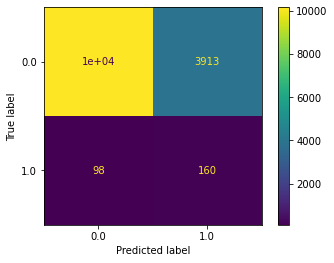

Accuracy:  71.99
F1-Score:  0.0739
Precision: 0.0393
Recall:    0.6202
MCC:       0.1008


In [ ]:
# Evaluate model
tempDF = get_model_metrics('BernoulliNB', nBayes)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Support Vector Classifier (SVC)

In [ ]:
%%time
# Load libraries
from sklearn.svm import SVC

# Create classification model
svc = SVC(class_weight='balanced')

# Fit model
svc.fit(X_over, y_over)

CPU times: user 1min 37s, sys: 350 ms, total: 1min 38s
Wall time: 1min 37s


[[10698  3363]
 [   74   184]]


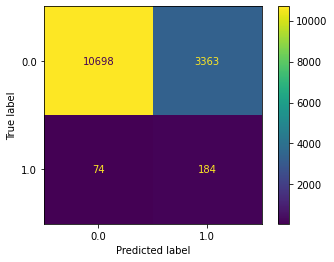

Accuracy:  76.0
F1-Score:  0.0967
Precision: 0.0519
Recall:    0.7132
MCC:       0.1461


In [ ]:
# Evaluate model
tempDF = get_model_metrics('SVC', svc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Linear SVC

In [ ]:
%%time
# Load libraries
from sklearn.svm import LinearSVC

# Create classification model
linSVC = LinearSVC(class_weight='balanced')

# Fit model
linSVC.fit(X_over, y_over)

CPU times: user 5.82 s, sys: 7.75 ms, total: 5.83 s
Wall time: 5.81 s


[[10260  3801]
 [   46   212]]


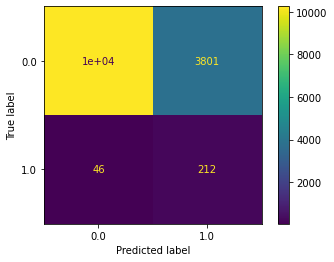

Accuracy:  73.13
F1-Score:  0.0993
Precision: 0.0528
Recall:    0.8217
MCC:       0.1633


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LinearSVC', linSVC)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Ada Boost Classifier

In [ ]:
%%time
# Load libraries
from sklearn.ensemble import AdaBoostClassifier

# Create classifier
adaboost = AdaBoostClassifier()

# Train model
adaboost.fit(X_over, y_over)

CPU times: user 1.74 s, sys: 17 ms, total: 1.76 s
Wall time: 1.76 s


[[12168  1893]
 [  104   154]]


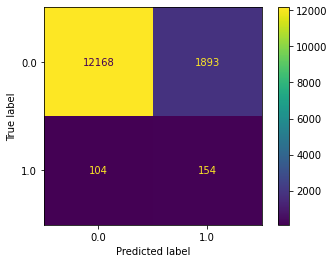

Accuracy:  86.05
F1-Score:  0.1336
Precision: 0.0752
Recall:    0.5969
MCC:       0.1757


In [ ]:
# Evaluate model
tempDF = get_model_metrics('AdaBoost', adaboost)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## MLP Classifier

In [ ]:
%%time
# Load libraries
from sklearn.neural_network import MLPClassifier

# Create classification model
mlp = MLPClassifier(early_stopping=True)

# Fit model
mlp.fit(X_over, y_over)

CPU times: user 28.3 s, sys: 21.2 s, total: 49.5 s
Wall time: 26.6 s


[[12137  1924]
 [  139   119]]


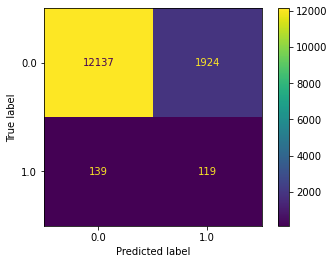

Accuracy:  85.59
F1-Score:  0.1034
Precision: 0.0582
Recall:    0.4612
MCC:       0.1234


In [ ]:
# Evaluate model
tempDF = get_model_metrics('MLP', mlp)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Gradient Boosting Classifier

In [ ]:
%%time
# Load libraries
from sklearn.ensemble import GradientBoostingClassifier

# Create classification model
gbc = GradientBoostingClassifier()

# Fit model
gbc.fit(X_over, y_over)

CPU times: user 5.46 s, sys: 24.1 ms, total: 5.48 s
Wall time: 5.49 s


[[12283  1778]
 [  107   151]]


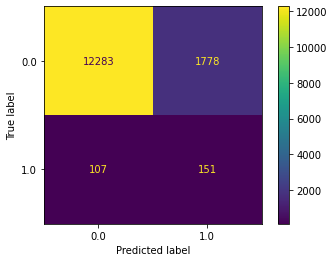

Accuracy:  86.84
F1-Score:  0.1381
Precision: 0.0783
Recall:    0.5853
MCC:       0.1788


In [ ]:
# Evaluate model
tempDF = get_model_metrics('GBC', gbc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## K-Nearest Neighbor

In [ ]:
%%time
# Load libraries
from sklearn.neighbors import KNeighborsClassifier

# Create classification model
knn = KNeighborsClassifier(2)

# Fit model
knn.fit(X_over, y_over)

CPU times: user 5.43 ms, sys: 2.05 ms, total: 7.48 ms
Wall time: 10.1 ms


[[13821   240]
 [  245    13]]


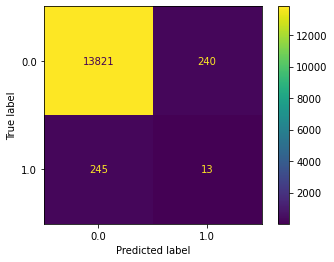

Accuracy:  96.61
F1-Score:  0.0509
Precision: 0.0514
Recall:    0.0504
MCC:       0.0336


In [ ]:
# Evaluate model
tempDF = get_model_metrics('KNN', knn)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Stochastic Gradient Descent

In [ ]:
%%time
# Load libraries
from sklearn.linear_model import SGDClassifier

# Create classification model
sgd = SGDClassifier(class_weight='balanced')

# Fit model
sgd.fit(X_over, y_over)

CPU times: user 272 ms, sys: 1.16 ms, total: 273 ms
Wall time: 272 ms


[[9275 4786]
 [  35  223]]


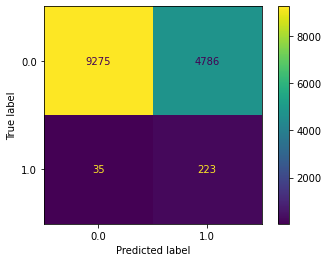

Accuracy:  66.33
F1-Score:  0.0847
Precision: 0.0445
Recall:    0.8643
MCC:       0.1461


In [ ]:
# Evaluate model
tempDF = get_model_metrics('SGD', sgd)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## LGBM Classifier

In [ ]:
%%time
# Load libraries
from lightgbm import LGBMClassifier

# Create classification model
lgbm = LGBMClassifier(class_weight='balanced')

# Fit model
lgbm.fit(X_over, y_over)

CPU times: user 820 ms, sys: 13.3 ms, total: 834 ms
Wall time: 843 ms


[[12458  1603]
 [  136   122]]


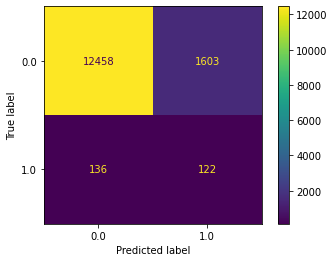

Accuracy:  87.86
F1-Score:  0.123
Precision: 0.0707
Recall:    0.4729
MCC:       0.1466


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LGBM', lgbm)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## XGBoost Classifier

In [ ]:
%%time
# Load libraries
from xgboost.sklearn import XGBClassifier

# Create classification model
xgbc = XGBClassifier(class_weight='balanced')

# Fit model
xgbc.fit(X_over, y_over)

CPU times: user 2.66 s, sys: 12.1 ms, total: 2.68 s
Wall time: 2.67 s


[[12184  1877]
 [  103   155]]


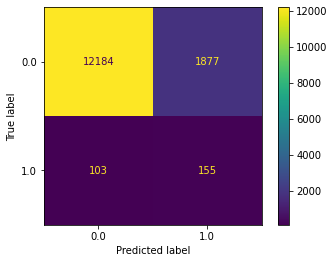

Accuracy:  86.17
F1-Score:  0.1354
Precision: 0.0763
Recall:    0.6008
MCC:       0.1781


In [ ]:
# Evaluate model
tempDF = get_model_metrics('XGBC', xgbc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Linear Discriminant Analysis

In [ ]:
%%time
# Load libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create classification model
lda = LinearDiscriminantAnalysis()

# Fit model
lda.fit(X_over, y_over)

CPU times: user 125 ms, sys: 4.05 ms, total: 129 ms
Wall time: 125 ms


[[11831  2230]
 [   91   167]]


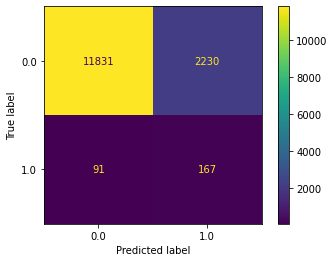

Accuracy:  83.79
F1-Score:  0.1258
Precision: 0.0697
Recall:    0.6473
MCC:       0.1741


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LDA', lda)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Compare Model Performance

In [ ]:
# compare model metrics
model_compare.sort_values('MCC', ascending=False, ignore_index=True)

,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,LogReg,84.18,0.1305,0.0724,0.6589,0.1811
1,GBC,86.84,0.1381,0.0783,0.5853,0.1788
2,XGBC,86.17,0.1354,0.0763,0.6008,0.1781
3,AdaBoost,86.05,0.1336,0.0752,0.5969,0.1757
4,LDA,83.79,0.1258,0.0697,0.6473,0.1741
5,LogReg,74.00,0.1018,0.0543,0.8178,0.1664
6,LinearSVC,73.13,0.0993,0.0528,0.8217,0.1633
7,LGBM,87.86,0.1230,0.0707,0.4729,0.1466
8,SVC,76.00,0.0967,0.0519,0.7132,0.1461
9,SGD,66.33,0.0847,0.0445,0.8643,0.1461


In [ ]:
# filter higher MCC and sort by Recall
table = model_compare.sort_values('MCC', ascending=False, ignore_index=True)
table[table['MCC'] > 0.15].sort_values('Recall', ascending=False)

,Model,Accuracy,F1_Score,Precision,Recall,MCC
6,LinearSVC,73.13,0.0993,0.0528,0.8217,0.1633
5,LogReg,74.00,0.1018,0.0543,0.8178,0.1664
0,LogReg,84.18,0.1305,0.0724,0.6589,0.1811
4,LDA,83.79,0.1258,0.0697,0.6473,0.1741
2,XGBC,86.17,0.1354,0.0763,0.6008,0.1781
3,AdaBoost,86.05,0.1336,0.0752,0.5969,0.1757
1,GBC,86.84,0.1381,0.0783,0.5853,0.1788


## Voting

In [ ]:
estimators=[('LinSVC', linSVC), ('LogReg', logit), ('LDA', lda), 
            ('XGBC', xgbc), ('AdaBoost', adaboost), ('GBC', gbc)]
            #  ('SGD', sgd), ('SVC', svc),  ('MLP', mlp), ('LGBM', lgbm) ]

In [ ]:
%%time
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(
    estimators=estimators,
    voting='hard'
)

eclf.fit(X_over, y_over)

CPU times: user 19.5 s, sys: 139 ms, total: 19.6 s
Wall time: 20.2 s


[[12158  1903]
 [   98   160]]


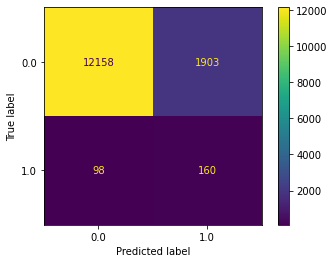

Accuracy:  86.03
F1-Score:  0.1379
Precision: 0.0776
Recall:    0.6202
MCC:       0.1836
CPU times: user 524 ms, sys: 113 ms, total: 638 ms
Wall time: 520 ms


,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,Voting,86.03,0.1379,0.0776,0.6202,0.1836


In [ ]:
%%time
get_model_metrics('Voting', eclf)

## Stacking

In [ ]:
%%time
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

final_estimator = LogisticRegression(solver='liblinear', 
                                     random_state=42, max_iter=500)

stk = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator
)

stk.fit(X_over, y_over)

CPU times: user 1min 18s, sys: 1.98 s, total: 1min 20s
Wall time: 1min 20s


[[12394  1667]
 [  130   128]]


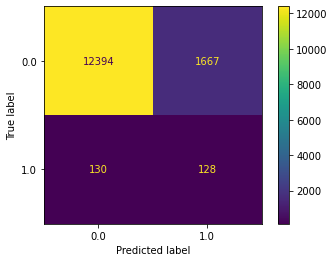

Accuracy:  87.45
F1-Score:  0.1247
Precision: 0.0713
Recall:    0.4961
MCC:       0.1517
CPU times: user 610 ms, sys: 109 ms, total: 719 ms
Wall time: 698 ms


,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,Stacking,87.45,0.1247,0.0713,0.4961,0.1517


In [ ]:
%%time
get_model_metrics('Stacking', stk)

# Hyperparameter Tuning

In [ ]:
# Load libraries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import matthews_corrcoef

In [ ]:
from sklearn.metrics import matthews_corrcoef, make_scorer
# # predictions = model.predict(X_test)
# # matthews_corrcoef(y_test, predictions)
# grid = GridSearchCV(model, parameter_space, scoring=matthews_corrcoef, cv=5)
mcc = make_scorer(matthews_corrcoef)

## [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
# Create classifier
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

# Get a baseline model
baseline = rfc.fit(X_over, y_over)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'n_estimators': [30, 100, 300, 1000], 
    'criterion': ['gini', 'entropy'], 
    'max_features': ['sqrt', 'log2', None], 
}
grid = GridSearchCV(rfc, parameter_space, cv=5)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_over, y_over)

CPU times: user 46min 23s, sys: 26.6 s, total: 46min 50s
Wall time: 49min 3s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1000} 

Baseline Accuracy:	98.14
Tuned Accuracy:		98.13


## [K-Nearest Neighbor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [ ]:
# Create classifier
knn = KNeighborsClassifier(2)

# Get a baseline model
# baseline = knn.fit(X_over, y_over)
baseline = knn.fit(X_ou_smote, y_ou_smote)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'weights': ['uniform', 'distance'], 
    'algorithm': ['ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [3, 10, 30, 100], 
}
# grid = GridSearchCV(knn, parameter_space, cv=5)
grid = GridSearchCV(knn, parameter_space, scoring=mcc, cv=5)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_ou_smote, y_ou_smote)

CPU times: user 28.6 s, sys: 5.49 s, total: 34.1 s
Wall time: 28.3 s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'algorithm': 'ball_tree', 'leaf_size': 3, 'weights': 'distance'} 

Baseline Accuracy:	90.74
Tuned Accuracy:		5.84


In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_over, y_over)

CPU times: user 12min 13s, sys: 21.3 s, total: 12min 35s
Wall time: 11min 26s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'algorithm': 'ball_tree', 'leaf_size': 3, 'weights': 'uniform'} 

Baseline Accuracy:	96.93
Tuned Accuracy:		96.93


## [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [ ]:
# Create decision tree regressor object
decisiontree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Get a baseline model
baseline = decisiontree.fit(X_over, y_over)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'criterion': ['gini', 'entropy', 'log_loss'], 
    'splitter': ['best', 'random'],
    'max_depth': [None, 3, 5, 7, 9],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': [0, 0.1, 0.01, 0.001]
}
grid = GridSearchCV(decisiontree, parameter_space, cv=5)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_over, y_over)

CPU times: user 16min 33s, sys: 6.7 s, total: 16min 40s
Wall time: 16min 43s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
9000 fits failed out of a total of 27000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9000 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_fail

In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'} 

Baseline Accuracy:	96.83
Tuned Accuracy:		96.75


## [LGBM Classifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [ ]:
# Create classifier
lgbm = LGBMClassifier(random_state=42, class_weight='balanced')

# Get a baseline model
baseline = lgbm.fit(X_over, y_over)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'boosting_type': ['gbdt', 'dart', 'goss', 'rf'], 
    'num_leaves': [10, 30, 100],
    'learning_rate': [.01, .1],
    'objective': [None, 'binary'],
    'min_child_weight': [1e-4, 1e-3, 1e-2],
    'min_child_samples': [20, 50]
}
grid = GridSearchCV(lgbm, parameter_space, cv=5)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_over, y_over)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
360 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 744, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 544, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py", line 197, in train
    b

CPU times: user 28min 42s, sys: 14.3 s, total: 28min 56s
Wall time: 28min 55s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'boosting_type': 'goss', 'learning_rate': 0.1, 'min_child_samples': 20, 'min_child_weight': 0.0001, 'num_leaves': 100, 'objective': None} 

Baseline Accuracy:	87.72
Tuned Accuracy:		95.64


## [MLP Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Too many options (2592 combinations). Using Randomized search of 30 of those, multiple times and will do grid search on the best options.

In [ ]:
import itertools
from sklearn.model_selection import RandomizedSearchCV

# Create classifier
mlp = MLPClassifier(early_stopping=True,
                    max_iter=1000,
                    random_state=42)

# Get a baseline model
baseline = mlp.fit(X_over, y_over)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'hidden_layer_sizes': [x for x in itertools.product((30,100),repeat=3)], #x8
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [1e-5, 1e-4, 1e-3],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [1e-4, 1e-3, 1e-2]
}
# grid = GridSearchCV(mlp, parameter_space, cv=5)
grid = RandomizedSearchCV(mlp, parameter_space, cv=5, n_iter=30, random_state=42)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_over, y_over)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

CPU times: user 9h 39min 34s, sys: 4h 42min 45s, total: 14h 22min 19s
Wall time: 7h 46min 17s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'solver': 'lbfgs', 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': (30, 100, 100), 'alpha': 0.001, 'activation': 'tanh'} 

Baseline Accuracy:	83.28
Tuned Accuracy:		96.33


In [ ]:
import itertools
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

# Create classifier
mlp = MLPClassifier(early_stopping=True,
                    max_iter=1000,
                    random_state=42)

# Get a baseline model
baseline = mlp.fit(X_over, y_over)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'hidden_layer_sizes': [x for x in itertools.product((30,100),repeat=3)], #x8
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1]
}
# grid = GridSearchCV(mlp, parameter_space, cv=5)
grid = RandomizedSearchCV(mlp, parameter_space, cv=5, n_iter=25, random_state=21)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_over, y_over)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

CPU times: user 6h 7min 1s, sys: 3h 5min 59s, total: 9h 13min 1s
Wall time: 4h 49min 53s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'solver': 'lbfgs', 'learning_rate_init': 0.0001, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (30, 30, 100), 'alpha': 1e-05, 'activation': 'tanh'} 

Baseline Accuracy:	83.28
Tuned Accuracy:		95.57


In [ ]:
import itertools
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

# Create classifier
mlp = MLPClassifier(early_stopping=True,
                    max_iter=1000,
                    random_state=42)

# Get a baseline model
baseline = mlp.fit(X_over, y_over)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'hidden_layer_sizes': [x for x in itertools.product((30,100),repeat=3)], #x8
    'activation': ['tanh'],#'identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs'],#, 'sgd', 'adam'],
    'alpha': [1e-5, 1e-4, 1e-3],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [1e-4, 1e-3, 1e-2]
}
# grid = GridSearchCV(mlp, parameter_space, cv=5)
grid = RandomizedSearchCV(mlp, parameter_space, cv=5, n_iter=25, random_state=7)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_over, y_over)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

NameError: ignored

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create classifier
logit = LogisticRegression(random_state=42, max_iter=500)

# Get a baseline model
baseline = logit.fit(X_over, y_over)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'tol': [1e-5, 1e-4, 1e-3],
    'C': [1, 0.9],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'l1_ratio': [0.5]
}
grid = GridSearchCV(logit, parameter_space, cv=5)
# grid = RandomizedSearchCV(logit, parameter_space, cv=5, n_iter=30, random_state=42)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_over, y_over)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Go

CPU times: user 30min 18s, sys: 1min 35s, total: 31min 54s
Wall time: 29min 49s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 0.9, 'l1_ratio': 0.5, 'penalty': 'l1', 'solver': 'saga', 'tol': 1e-05} 

Baseline Accuracy:	73.95
Tuned Accuracy:		73.97


In [ ]:
from sklearn.linear_model import LogisticRegression

# Create classifier
logit = LogisticRegression(random_state=42, max_iter=500)

# Get a baseline model
baseline = logit.fit(X_over, y_over)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'tol': [1e-7, 1e-6, 1e-5, 1e-4],
    'C': [1, 0.9, 0.8, 0.7],
    'solver': ['saga'],#'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'l1_ratio': [0.4, 0.5, 0.6]
}
grid = GridSearchCV(logit, parameter_space, cv=5)
# grid = RandomizedSearchCV(logit, parameter_space, cv=5, n_iter=30, random_state=42)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_over, y_over)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/loca

CPU times: user 2h 4min 5s, sys: 1min 44s, total: 2h 5min 50s
Wall time: 2h 4min 32s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 0.8, 'l1_ratio': 0.4, 'penalty': 'l1', 'solver': 'saga', 'tol': 1e-07} 

Baseline Accuracy:	73.95
Tuned Accuracy:		73.97


maybe try with the imbalanced dataset? (X_train, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create classifier
logit = LogisticRegression(random_state=42, max_iter=500)

# Get a baseline model
baseline = logit.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'tol': [1e-5, 1e-4, 1e-3],
    'C': [1, 0.9],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'l1_ratio': [0.5]
}
grid = GridSearchCV(logit, parameter_space, cv=5)
# grid = RandomizedSearchCV(logit, parameter_space, cv=5, n_iter=30, random_state=42)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Go

CPU times: user 8min 11s, sys: 51.3 s, total: 9min 2s
Wall time: 7min 57s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 1, 'l1_ratio': 0.5, 'penalty': 'none', 'solver': 'newton-cg', 'tol': 1e-05} 

Baseline Accuracy:	98.2
Tuned Accuracy:		98.2


In [ ]:
%%time
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create classifier
logit = LogisticRegression(random_state=42, max_iter=500, C=1, 
                                 l1_ratio=0.5, penalty='none', 
                                 solver='newton-cg', tol=1e-05)

# Train model
logit.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


CPU times: user 726 ms, sys: 575 ms, total: 1.3 s
Wall time: 1.02 s


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LogReg', logit)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

[[14061     0]
 [  258     0]]
Accuracy:  98.2
F1-Score:  0.9731
Precision: 0.9643
Recall:    0.982


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
%%time
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create classifier
logit = LogisticRegression(random_state=42, max_iter=500, C=1,
                           penalty='elasticnet', solver='saga', l1_ratio=0.5) 
                                #  l1_ratio=0.5, penalty='none', 
                                #  solver='newton-cg', tol=1e-05)

# Train model
logit.fit(X_train, y_train)

CPU times: user 2.68 s, sys: 846 µs, total: 2.69 s
Wall time: 3.1 s


[[14061     0]
 [  258     0]]


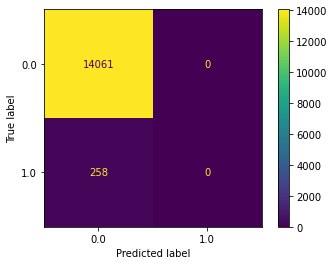

Accuracy:  98.2
F1-Score:  0.9731
Precision: 0.9643
Recall:    0.982


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LogReg_elasticnet-saga', logit)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

In [ ]:
# compare model metrics
model_compare.sort_values('Accuracy', ascending=False, ignore_index=True)

,Model,Accuracy,F1_Score,Precision,Recall
0,LogReg_l1-liblinear,98.2,0.9731,0.9643,0.982
1,LogReg_l1-saga,98.2,0.9731,0.9643,0.982
2,LogReg_l2-newton-cg,98.2,0.9731,0.9643,0.982
3,LogReg_l2-lbfgs,98.2,0.9731,0.9643,0.982
4,LogReg_l2-liblinear,98.2,0.9731,0.9643,0.982
5,LogReg_l2-sag,98.2,0.9731,0.9643,0.982
6,LogReg_l2-saga,98.2,0.9731,0.9643,0.982
7,LogReg_elasticnet-saga,98.2,0.9731,0.9643,0.982


## XGBoost Classifier

In [ ]:
%%time
# Load libraries
from xgboost.sklearn import XGBClassifier

# Create classification model
xgbc = XGBClassifier(class_weight='balanced')

# Fit model
xgbc.fit(X_train, y_train)

CPU times: user 1.84 s, sys: 7.32 ms, total: 1.85 s
Wall time: 1.85 s


[[14061     0]
 [  258     0]]


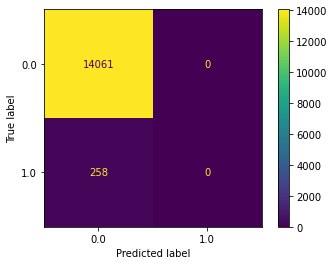

Accuracy:  98.2
F1-Score:  0.9731
Precision: 0.9643
Recall:    0.982


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Evaluate model
tempDF = get_model_metrics('XGBC', xgbc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

In [ ]:
# Load libraries
from xgboost.sklearn import XGBClassifier

# Create classifier
xgb = XGBClassifier(random_state=42)

# Get a baseline model
baseline = xgb.fit(X_over, y_over)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'n_estimators': [30, 100, 300, 1000], 
    'criterion': ['gini', 'entropy'], 
    'max_features': ['sqrt', 'log2', None], 
}
grid = GridSearchCV(xgb, parameter_space, cv=5)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_over, y_over)

CPU times: user 46min 23s, sys: 26.6 s, total: 46min 50s
Wall time: 49min 3s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1000} 

Baseline Accuracy:	98.14
Tuned Accuracy:		98.13


In [ ]:
## SEPARATE DATA FROM TARGET
X, y = DF.iloc[:,:-1], DF.iloc[:,-1]

## SPLIT TRAINING AND TEST SETS
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.33, random_state=42, 
  stratify=y) # stratify to maintain proportion of target variable

https://towardsdatascience.com/getting-started-with-xgboost-in-scikit-learn-f69f5f470a97

In [ ]:
## SEPARATE DATA FROM TARGET
X, y = DF.iloc[:,:-1], DF.iloc[:,-1]

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

scores = cross_val_score(XGBClassifier(), X_over, y_over)

In [ ]:
# get root mean squared error
scores

array([0.82299877, 0.81704327, 0.82422491, 0.82510072, 0.83342091])

In [ ]:
# or get the average
scores.mean()

0.9819539530176533

In [ ]:
%%time
# Load libraries
from xgboost import XGBClassifier

# Create classification model
xgbc = XGBClassifier(scale_pos_weight=1.5, min_child_weight=.8, max_delta_step=5, objective='binary:logistic')

# Fit model
xgbc.fit(X_over, y_over)

CPU times: user 1min 18s, sys: 1.32 s, total: 1min 19s
Wall time: 45.7 s


[[13723   338]
 [  219    39]]


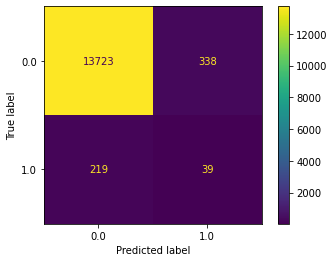

Accuracy:  96.11
F1-Score:  0.9647
Precision: 0.9684
Recall:    0.9611


In [ ]:
# Evaluate model
tempDF = get_model_metrics('XGBC', xgbc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Keras

In [ ]:
X_over.shape

(57090, 17)

In [ ]:
class BinaryTruePositives(tf.keras.metrics.Metric):

  def __init__(self, name='binary_true_positives', **kwargs):
    super(BinaryTruePositives, self).__init__(name=name, **kwargs)
    self.true_positives = self.add_weight(name='tp', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)

    values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    values = tf.cast(values, self.dtype)
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, self.dtype)
      values = tf.multiply(values, sample_weight)
    self.true_positives.assign_add(tf.reduce_sum(values))

  def result(self):
    return self.true_positives

  def reset_states(self):
    self.true_positives.assign(0)

In [ ]:
from keras import models
from keras import layers
import tensorflow as tf

network = models.Sequential()

network.add(layers.Dense(units=17, activation='relu', input_shape=(17,)))
network.add(layers.Dense(units=1, activation='sigmoid'))

network.compile(loss='binary_crossentropy', 
                optimizer='rmsprop',
                metrics=[BinaryTruePositives(), 'binary_accuracy', 'AUC', 'MeanSquaredError'])

In [ ]:
history = network.fit(X_train, y_train,
                      epochs=10,
                      verbose=1,
                      batch_size=100,
                      validation_data=(X_test, y_test))

Epoch 1/10
 37/291 [==>...........................] - ETA: 1s - loss: 0.0684 - binary_true_positives: 61.0000 - binary_accuracy: 0.9835 - auc: 0.8604 - mean_squared_error: 0.0155

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2034: UserWarning: Metric BinaryTruePositives implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


291/291 [==============================] - 2s 5ms/step - loss: 0.0751 - binary_true_positives: 525.0000 - binary_accuracy: 0.9819 - auc: 0.8471 - mean_squared_error: 0.0170 - val_loss: 0.0776 - val_binary_true_positives: 258.0000 - val_binary_accuracy: 0.9820 - val_auc: 0.8261 - val_mean_squared_error: 0.0173
Epoch 2/10
291/291 [==============================] - 2s 6ms/step - loss: 0.0746 - binary_true_positives: 525.0000 - binary_accuracy: 0.9819 - auc: 0.8491 - mean_squared_error: 0.0170 - val_loss: 0.0770 - val_binary_true_positives: 258.0000 - val_binary_accuracy: 0.9820 - val_auc: 0.8299 - val_mean_squared_error: 0.0172
Epoch 3/10
291/291 [==============================] - 2s 7ms/step - loss: 0.0742 - binary_true_positives: 525.0000 - binary_accuracy: 0.9819 - auc: 0.8518 - mean_squared_error: 0.0170 - val_loss: 0.0769 - val_binary_true_positives: 258.0000 - val_binary_accuracy: 0.9820 - val_auc: 0.8304 - val_mean_squared_error: 0.0172
Epoch 4/10
291/291 [=========================

# [Compare Classification Methods](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
over (SMOTE)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef

# Set up DataFrame to store comparisons
model_compare = pd.DataFrame()

def get_model_metrics(name, model):
  '''Prints confusion matrix and some metrics; returns metrics in a DF'''
  cols = ['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall', 'MCC']
    # get predictions
  predictions = model.predict(X_test)
  
  # print confusion matrix
  cm = confusion_matrix(y_test, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=model.classes_)
  print(cm)
  disp.plot()
  plt.show()  
  
  # get accuracy, f1-score, precision, and recall
  # accuracy = round(model.score(X_test, y_test)*100, 2)
  cr = classification_report(y_test, predictions, output_dict=True)
  accuracy = round(cr['accuracy']*100, 2)
  print('Accuracy: ', accuracy)
  f1Score = round(cr['1.0']['f1-score'], 4)
  print('F1-Score: ', f1Score)
  precision = round(cr['1.0']['precision'], 4)
  print('Precision:', precision)
  recall = round(cr['1.0']['recall'], 4)
  print('Recall:   ', recall)
  MCC = round(matthews_corrcoef(y_test, predictions), 4)
  print('MCC:      ', MCC)

  df = pd.DataFrame([[name, accuracy, f1Score, precision, recall, MCC]],
                    columns=cols)
  return df

## Random Forest

In [ ]:
%%time
# Load libraries
from sklearn.ensemble import RandomForestClassifier

# Create classifier
rfClass = RandomForestClassifier(class_weight='balanced')

# Train model
rfClass.fit(X_smote, y_smote)

CPU times: user 7.1 s, sys: 29.8 ms, total: 7.13 s
Wall time: 7.39 s


[[13604   457]
 [  239    19]]


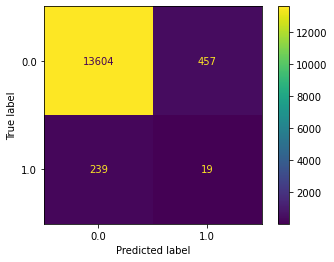

Accuracy:  95.14
F1-Score:  0.0518
Precision: 0.0399
Recall:    0.0736
MCC:       0.0305


In [ ]:
# Evaluate model
tempDF = get_model_metrics('RandomForest', rfClass)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Decision Tree

In [ ]:
%%time
# Load libraries
from sklearn.tree import DecisionTreeClassifier

# Create decision tree regressor object
decisiontree = DecisionTreeClassifier(class_weight='balanced')

# Train model
decisiontree.fit(X_smote, y_smote)

CPU times: user 377 ms, sys: 1.97 ms, total: 379 ms
Wall time: 404 ms


[[13607   454]
 [  236    22]]


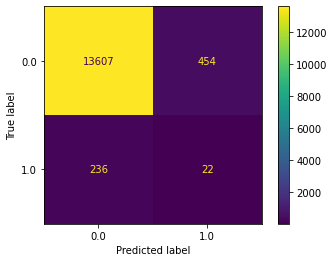

Accuracy:  95.18
F1-Score:  0.0599
Precision: 0.0462
Recall:    0.0853
MCC:       0.0393


In [ ]:
# Evaluate model
tempDF = get_model_metrics('DecisionTree', decisiontree)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Logistic Regression

In [ ]:
%%time
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create logistic regression
logit = LogisticRegression(class_weight='balanced')

# Train model
logit.fit(X_smote, y_smote)

CPU times: user 1.07 s, sys: 711 ms, total: 1.78 s
Wall time: 1.49 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[10435  3626]
 [   50   208]]


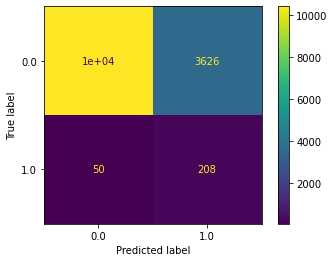

Accuracy:  74.33
F1-Score:  0.1017
Precision: 0.0543
Recall:    0.8062
MCC:       0.1647


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LogReg', logit)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

In [ ]:
%%time
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create logistic regression
logit = LogisticRegression(class_weight='balanced',
                           solver='liblinear')

# Train model
logit.fit(X_smote, y_smote)

CPU times: user 475 ms, sys: 13.6 ms, total: 489 ms
Wall time: 536 ms


[[10436  3625]
 [   50   208]]


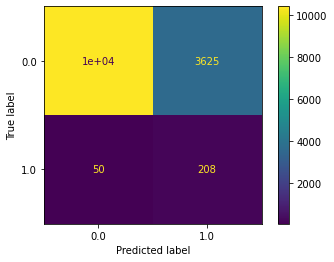

Accuracy:  74.33
F1-Score:  0.1017
Precision: 0.0543
Recall:    0.8062
MCC:       0.1648


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LogReg', logit)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Gaussian Naive Bayes Classifier

In [ ]:
%%time
# Load libraries
from sklearn.naive_bayes import GaussianNB

# Create Gaussian naive Bayes object
nBayes = GaussianNB()

# Fit model
nBayes.fit(X_smote, y_smote)

CPU times: user 27.3 ms, sys: 110 µs, total: 27.4 ms
Wall time: 60.1 ms


[[ 3874 10187]
 [    2   256]]


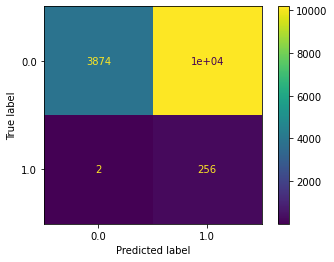

Accuracy:  28.84
F1-Score:  0.0478
Precision: 0.0245
Recall:    0.9922
MCC:       0.0802


In [ ]:
# Evaluate model
tempDF = get_model_metrics('GaussianNB', nBayes)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

In [ ]:
%%time
# Load libraries
from sklearn.naive_bayes import BernoulliNB

# Create Gaussian naive Bayes object
nBayes = BernoulliNB()

# Fit model
nBayes.fit(X_smote, y_smote)

CPU times: user 32.6 ms, sys: 3.88 ms, total: 36.5 ms
Wall time: 63.2 ms


[[9884 4177]
 [  89  169]]


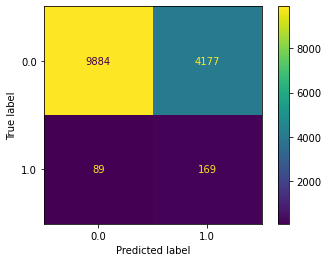

Accuracy:  70.21
F1-Score:  0.0734
Precision: 0.0389
Recall:    0.655
MCC:       0.1036


In [ ]:
# Evaluate model
tempDF = get_model_metrics('BernoulliNB', nBayes)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Support Vector Classifier (SVC)

In [ ]:
%%time
# Load libraries
from sklearn.svm import SVC

# Create classification model
svc = SVC(class_weight='balanced')

# Fit model
svc.fit(X_smote, y_smote)

CPU times: user 1min 24s, sys: 183 ms, total: 1min 24s
Wall time: 1min 27s


[[11172  2889]
 [  107   151]]


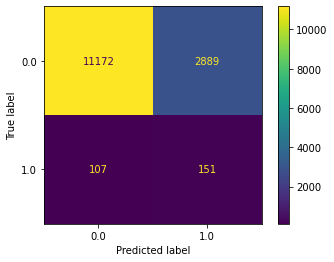

Accuracy:  79.08
F1-Score:  0.0916
Precision: 0.0497
Recall:    0.5853
MCC:       0.1235


In [ ]:
# Evaluate model
tempDF = get_model_metrics('SVC', svc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Linear SVC

In [ ]:
%%time
# Load libraries
from sklearn.svm import LinearSVC

# Create classification model
linSVC = LinearSVC(class_weight='balanced')

# Fit model
linSVC.fit(X_smote, y_smote)

CPU times: user 3.89 s, sys: 17.9 ms, total: 3.9 s
Wall time: 3.9 s


[[10330  3731]
 [   48   210]]


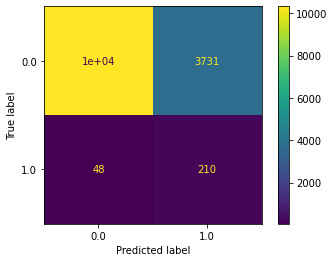

Accuracy:  73.61
F1-Score:  0.1
Precision: 0.0533
Recall:    0.814
MCC:       0.1634


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LinearSVC', linSVC)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Ada Boost Classifier

In [ ]:
%%time
# Load libraries
from sklearn.ensemble import AdaBoostClassifier

# Create classifier
adaboost = AdaBoostClassifier()

# Train model
adaboost.fit(X_smote, y_smote)

CPU times: user 2.01 s, sys: 16 ms, total: 2.03 s
Wall time: 2.02 s


[[12362  1699]
 [  132   126]]


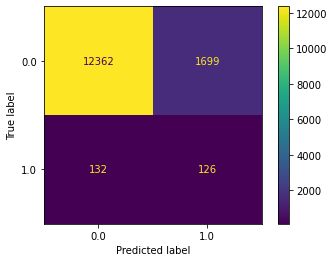

Accuracy:  87.21
F1-Score:  0.121
Precision: 0.069
Recall:    0.4884
MCC:       0.1466


In [ ]:
# Evaluate model
tempDF = get_model_metrics('AdaBoost', adaboost)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## MLP Classifier

In [ ]:
%%time
# Load libraries
from sklearn.neural_network import MLPClassifier

# Create classification model
mlp = MLPClassifier(early_stopping=True)

# Fit model
mlp.fit(X_smote, y_smote)

CPU times: user 26.8 s, sys: 20.2 s, total: 47 s
Wall time: 24.1 s


[[12246  1815]
 [  149   109]]


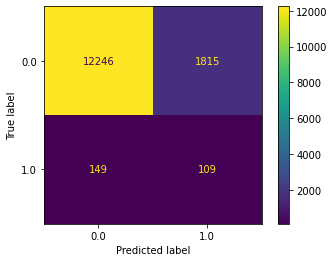

Accuracy:  86.28
F1-Score:  0.0999
Precision: 0.0567
Recall:    0.4225
MCC:       0.1144


In [ ]:
# Evaluate model
tempDF = get_model_metrics('MLP', mlp)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Gradient Boosting Classifier

In [ ]:
%%time
# Load libraries
from sklearn.ensemble import GradientBoostingClassifier

# Create classification model
gbc = GradientBoostingClassifier()

# Fit model
gbc.fit(X_smote, y_smote)

CPU times: user 6.88 s, sys: 27.9 ms, total: 6.9 s
Wall time: 6.88 s


[[13179   882]
 [  201    57]]


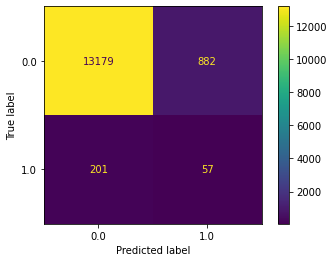

Accuracy:  92.44
F1-Score:  0.0952
Precision: 0.0607
Recall:    0.2209
MCC:       0.085


In [ ]:
# Evaluate model
tempDF = get_model_metrics('GBC', gbc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## K-Nearest Neighbor

In [ ]:
%%time
# Load libraries
from sklearn.neighbors import KNeighborsClassifier

# Create classification model
knn = KNeighborsClassifier(2)

# Fit model
knn.fit(X_smote, y_smote)

CPU times: user 7.48 ms, sys: 0 ns, total: 7.48 ms
Wall time: 6.94 ms


[[13425   636]
 [  226    32]]


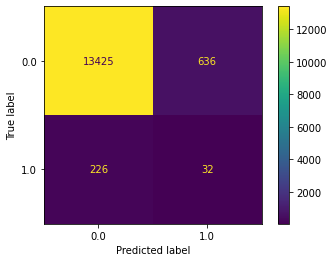

Accuracy:  93.98
F1-Score:  0.0691
Precision: 0.0479
Recall:    0.124
MCC:       0.0497


In [ ]:
# Evaluate model
tempDF = get_model_metrics('KNN', knn)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Stochastic Gradient Descent

In [ ]:
%%time
# Load libraries
from sklearn.linear_model import SGDClassifier

# Create classification model
sgd = SGDClassifier(class_weight='balanced')

# Fit model
sgd.fit(X_smote, y_smote)

CPU times: user 273 ms, sys: 1.04 ms, total: 274 ms
Wall time: 279 ms


[[8920 5141]
 [  28  230]]


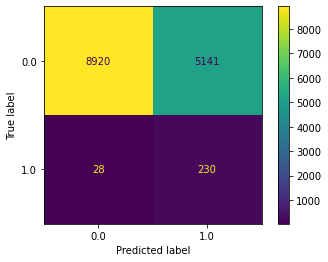

Accuracy:  63.9
F1-Score:  0.0817
Precision: 0.0428
Recall:    0.8915
MCC:       0.1445


In [ ]:
# Evaluate model
tempDF = get_model_metrics('SGD', sgd)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## LGBM Classifier

In [ ]:
%%time
# Load libraries
from lightgbm import LGBMClassifier

# Create classification model
lgbm = LGBMClassifier(class_weight='balanced')

# Fit model
lgbm.fit(X_smote, y_smote)

CPU times: user 1.01 s, sys: 20.8 ms, total: 1.03 s
Wall time: 1.02 s


[[13814   247]
 [  231    27]]


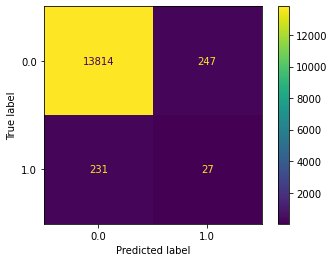

Accuracy:  96.66
F1-Score:  0.1015
Precision: 0.0985
Recall:    0.1047
MCC:       0.0846


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LGBM', lgbm)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## XGBoost Classifier

In [ ]:
%%time
# Load libraries
from xgboost.sklearn import XGBClassifier

# Create classification model
xgbc = XGBClassifier(class_weight='balanced')

# Fit model
xgbc.fit(X_smote, y_smote)

CPU times: user 2.83 s, sys: 8.72 ms, total: 2.84 s
Wall time: 2.83 s


[[12735  1326]
 [  170    88]]


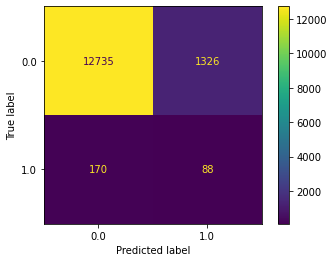

Accuracy:  89.55
F1-Score:  0.1053
Precision: 0.0622
Recall:    0.3411
MCC:       0.11


In [ ]:
# Evaluate model
tempDF = get_model_metrics('XGBC', xgbc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Linear Discriminant Analysis

In [ ]:
%%time
# Load libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create classification model
lda = LinearDiscriminantAnalysis()

# Fit model
lda.fit(X_smote, y_smote)

CPU times: user 130 ms, sys: 10.9 ms, total: 140 ms
Wall time: 130 ms


[[11721  2340]
 [   84   174]]


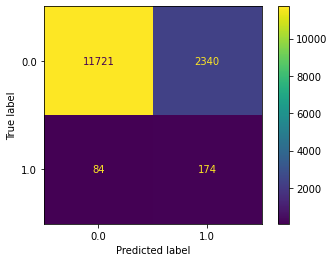

Accuracy:  83.07
F1-Score:  0.1255
Precision: 0.0692
Recall:    0.6744
MCC:       0.1776


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LDA', lda)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Compare Model Performance

In [ ]:
# compare model metrics
model_compare.sort_values('MCC', ascending=False, ignore_index=True)

,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,LDA,83.07,0.1255,0.0692,0.6744,0.1776
1,LogReg,74.33,0.1017,0.0543,0.8062,0.1647
2,LinearSVC,73.61,0.1000,0.0533,0.8140,0.1634
3,AdaBoost,87.21,0.1210,0.0690,0.4884,0.1466
4,SGD,63.90,0.0817,0.0428,0.8915,0.1445
5,SVC,79.08,0.0916,0.0497,0.5853,0.1235
6,MLP,86.28,0.0999,0.0567,0.4225,0.1144
7,XGBC,89.55,0.1053,0.0622,0.3411,0.1100
8,BernoulliNB,70.21,0.0734,0.0389,0.6550,0.1036
9,GBC,92.44,0.0952,0.0607,0.2209,0.0850


In [ ]:
# filter higher MCC and sort by Recall
table = model_compare.sort_values('MCC', ascending=False, ignore_index=True)
table[table['MCC'] > 0.14].sort_values('Recall', ascending=False)

,Model,Accuracy,F1_Score,Precision,Recall,MCC
4,SGD,63.90,0.0817,0.0428,0.8915,0.1445
2,LinearSVC,73.61,0.1000,0.0533,0.8140,0.1634
1,LogReg,74.33,0.1017,0.0543,0.8062,0.1647
0,LDA,83.07,0.1255,0.0692,0.6744,0.1776
3,AdaBoost,87.21,0.1210,0.0690,0.4884,0.1466


## Voting

In [ ]:
estimators=[('SGD', sgd), ('LinSVC', linSVC), ('LogReg', logit)]#, 
            # ('LDA', lda), ('AdaBoost', adaboost)]
            
            # ('XGBC', xgbc), ('GBC', gbc)]
            #   ('SVC', svc),  ('MLP', mlp), ('LGBM', lgbm) ]

In [ ]:
%%time
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(
    estimators=estimators,
    voting='hard'
)

eclf.fit(X_smote, y_smote)

CPU times: user 6.06 s, sys: 607 ms, total: 6.66 s
Wall time: 5.96 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[10366  3695]
 [   49   209]]


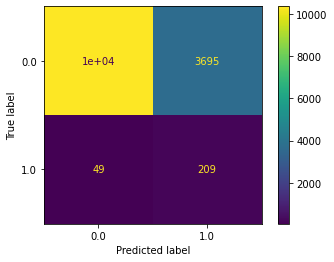

Accuracy:  73.85
F1-Score:  0.1004
Precision: 0.0535
Recall:    0.8101
MCC:       0.1635
CPU times: user 359 ms, sys: 111 ms, total: 470 ms
Wall time: 354 ms


,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,Voting,73.85,0.1004,0.0535,0.8101,0.1635


In [ ]:
%%time
get_model_metrics('Voting', eclf)

## Stacking

In [ ]:
%%time
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

final_estimator = LogisticRegression(solver='liblinear', 
                                     random_state=42, max_iter=500)

stk = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator
)

stk.fit(X_smote, y_smote)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


CPU times: user 25.6 s, sys: 4.64 s, total: 30.3 s
Wall time: 25.7 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[11784  2277]
 [   86   172]]


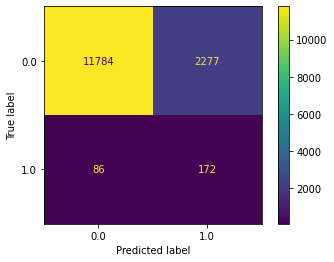

Accuracy:  83.5
F1-Score:  0.1271
Precision: 0.0702
Recall:    0.6667
MCC:       0.1783
CPU times: user 354 ms, sys: 89.3 ms, total: 443 ms
Wall time: 413 ms


,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,Stacking,83.5,0.1271,0.0702,0.6667,0.1783


In [ ]:
%%time
get_model_metrics('Stacking', stk)

# [Compare Classification Methods](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
over (SMOTE), under

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef

# Set up DataFrame to store comparisons
model_compare = pd.DataFrame()

def get_model_metrics(name, model):
  '''Prints confusion matrix and some metrics; returns metrics in a DF'''
  cols = ['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall', 'MCC']
    # get predictions
  predictions = model.predict(X_test)
  
  # print confusion matrix
  cm = confusion_matrix(y_test, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=model.classes_)
  print(cm)
  disp.plot()
  plt.show()  
  
  # get accuracy, f1-score, precision, and recall
  # accuracy = round(model.score(X_test, y_test)*100, 2)
  cr = classification_report(y_test, predictions, output_dict=True)
  accuracy = round(cr['accuracy']*100, 2)
  print('Accuracy: ', accuracy)
  f1Score = round(cr['1.0']['f1-score'], 4)
  print('F1-Score: ', f1Score)
  precision = round(cr['1.0']['precision'], 4)
  print('Precision:', precision)
  recall = round(cr['1.0']['recall'], 4)
  print('Recall:   ', recall)
  MCC = round(matthews_corrcoef(y_test, predictions), 4)
  print('MCC:      ', MCC)

  df = pd.DataFrame([[name, accuracy, f1Score, precision, recall, MCC]],
                    columns=cols)
  return df

## Random Forest

In [ ]:
%%time
# Load libraries
from sklearn.ensemble import RandomForestClassifier

# Create classifier
rfClass = RandomForestClassifier(class_weight='balanced')

# Train model
rfClass.fit(X_ou_smote, y_ou_smote)

CPU times: user 999 ms, sys: 6.88 ms, total: 1.01 s
Wall time: 1.03 s


[[13049  1012]
 [  189    69]]


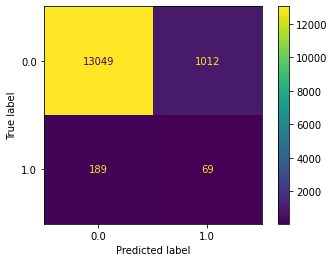

Accuracy:  91.61
F1-Score:  0.1031
Precision: 0.0638
Recall:    0.2674
MCC:       0.0984


In [ ]:
# Evaluate model
tempDF = get_model_metrics('RandomForest', rfClass)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Decision Tree

In [ ]:
%%time
# Load libraries
from sklearn.tree import DecisionTreeClassifier

# Create decision tree regressor object
decisiontree = DecisionTreeClassifier(class_weight='balanced')

# Train model
decisiontree.fit(X_ou_smote, y_ou_smote)

CPU times: user 48.1 ms, sys: 1.1 ms, total: 49.2 ms
Wall time: 49.2 ms


[[12684  1377]
 [  179    79]]


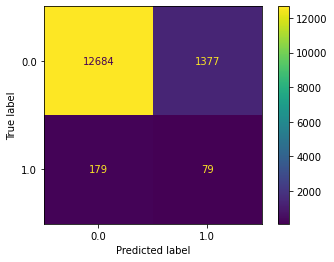

Accuracy:  89.13
F1-Score:  0.0922
Precision: 0.0543
Recall:    0.3062
MCC:       0.0917


In [ ]:
# Evaluate model
tempDF = get_model_metrics('DecisionTree', decisiontree)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Logistic Regression

In [ ]:
%%time
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create logistic regression
logit = LogisticRegression(class_weight='balanced')

# Train model
logit.fit(X_ou_smote, y_ou_smote)

CPU times: user 205 ms, sys: 131 ms, total: 336 ms
Wall time: 187 ms


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[10395  3666]
 [   49   209]]


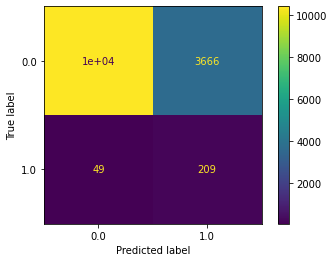

Accuracy:  74.06
F1-Score:  0.1011
Precision: 0.0539
Recall:    0.8101
MCC:       0.1645


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LogReg', logit)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

In [ ]:
%%time
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create logistic regression
logit = LogisticRegression(class_weight='balanced',
                           solver='liblinear')

# Train model
logit.fit(X_ou_smote, y_ou_smote)

CPU times: user 46.1 ms, sys: 913 µs, total: 47 ms
Wall time: 47.9 ms


[[10396  3665]
 [   49   209]]


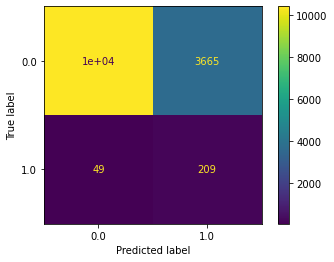

Accuracy:  74.06
F1-Score:  0.1012
Precision: 0.0539
Recall:    0.8101
MCC:       0.1645


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LogReg', logit)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Gaussian Naive Bayes Classifier

In [ ]:
%%time
# Load libraries
from sklearn.naive_bayes import GaussianNB

# Create Gaussian naive Bayes object
nBayes = GaussianNB()

# Fit model
nBayes.fit(X_ou_smote, y_ou_smote)

CPU times: user 8.05 ms, sys: 5 µs, total: 8.06 ms
Wall time: 7.62 ms


[[ 3500 10561]
 [    2   256]]


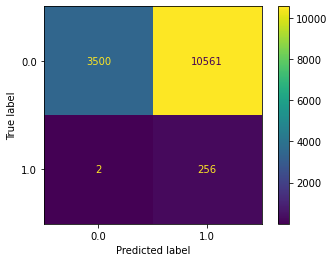

Accuracy:  26.23
F1-Score:  0.0462
Precision: 0.0237
Recall:    0.9922
MCC:       0.0746


In [ ]:
# Evaluate model
tempDF = get_model_metrics('GaussianNB', nBayes)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

In [ ]:
%%time
# Load libraries
from sklearn.naive_bayes import BernoulliNB

# Create Gaussian naive Bayes object
nBayes = BernoulliNB()

# Fit model
nBayes.fit(X_ou_smote, y_ou_smote)

CPU times: user 10.6 ms, sys: 1.16 ms, total: 11.8 ms
Wall time: 11.2 ms


[[9947 4114]
 [  92  166]]


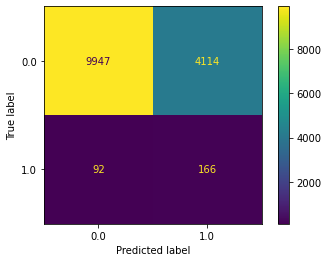

Accuracy:  70.63
F1-Score:  0.0732
Precision: 0.0388
Recall:    0.6434
MCC:       0.1019


In [ ]:
# Evaluate model
tempDF = get_model_metrics('BernoulliNB', nBayes)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Support Vector Classifier (SVC)

In [ ]:
%%time
# Load libraries
from sklearn.svm import SVC

# Create classification model
svc = SVC(class_weight='balanced')

# Fit model
svc.fit(X_ou_smote, y_ou_smote)

CPU times: user 2.85 s, sys: 148 ms, total: 3 s
Wall time: 3 s


[[10552  3509]
 [   63   195]]


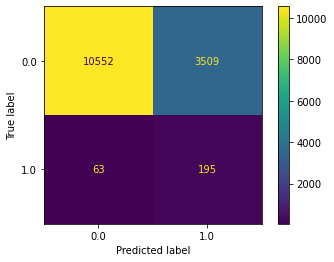

Accuracy:  75.05
F1-Score:  0.0984
Precision: 0.0526
Recall:    0.7558
MCC:       0.1538


In [ ]:
# Evaluate model
tempDF = get_model_metrics('SVC', svc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Linear SVC

In [ ]:
%%time
# Load libraries
from sklearn.svm import LinearSVC

# Create classification model
linSVC = LinearSVC(class_weight='balanced')

# Fit model
linSVC.fit(X_ou_smote, y_ou_smote)

CPU times: user 669 ms, sys: 1.08 ms, total: 670 ms
Wall time: 691 ms


[[10259  3802]
 [   48   210]]


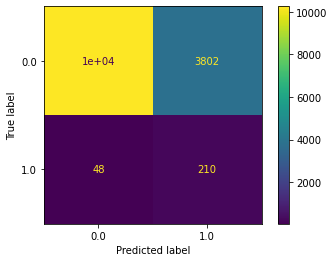

Accuracy:  73.11
F1-Score:  0.0984
Precision: 0.0523
Recall:    0.814
MCC:       0.161


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LinearSVC', linSVC)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Ada Boost Classifier

In [ ]:
%%time
# Load libraries
from sklearn.ensemble import AdaBoostClassifier

# Create classifier
adaboost = AdaBoostClassifier()

# Train model
adaboost.fit(X_ou_smote, y_ou_smote)

CPU times: user 616 ms, sys: 4.45 ms, total: 621 ms
Wall time: 670 ms


[[11938  2123]
 [  109   149]]


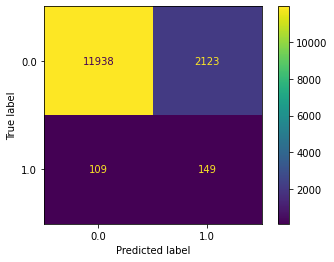

Accuracy:  84.41
F1-Score:  0.1178
Precision: 0.0656
Recall:    0.5775
MCC:       0.1553


In [ ]:
# Evaluate model
tempDF = get_model_metrics('AdaBoost', adaboost)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## MLP Classifier

In [ ]:
%%time
# Load libraries
from sklearn.neural_network import MLPClassifier

# Create classification model
mlp = MLPClassifier(early_stopping=True)

# Fit model
mlp.fit(X_ou_smote, y_ou_smote)

CPU times: user 2.16 s, sys: 2.23 s, total: 4.39 s
Wall time: 3.37 s


[[11919  2142]
 [  101   157]]


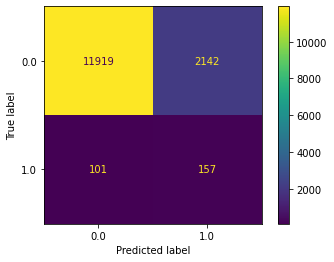

Accuracy:  84.34
F1-Score:  0.1228
Precision: 0.0683
Recall:    0.6085
MCC:       0.1653


In [ ]:
# Evaluate model
tempDF = get_model_metrics('MLP', mlp)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Gradient Boosting Classifier

In [ ]:
%%time
# Load libraries
from sklearn.ensemble import GradientBoostingClassifier

# Create classification model
gbc = GradientBoostingClassifier()

# Fit model
gbc.fit(X_ou_smote, y_ou_smote)

CPU times: user 1.74 s, sys: 5.9 ms, total: 1.75 s
Wall time: 2.04 s


[[12600  1461]
 [  140   118]]


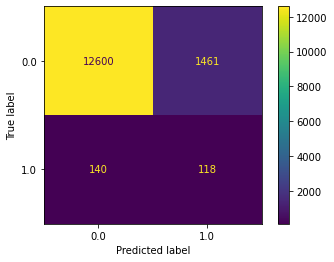

Accuracy:  88.82
F1-Score:  0.1285
Precision: 0.0747
Recall:    0.4574
MCC:       0.1501


In [ ]:
# Evaluate model
tempDF = get_model_metrics('GBC', gbc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## K-Nearest Neighbor

In [ ]:
%%time
# Load libraries
from sklearn.neighbors import KNeighborsClassifier

# Create classification model
knn = KNeighborsClassifier(2)

# Fit model
knn.fit(X_ou_smote, y_ou_smote)

CPU times: user 2.03 ms, sys: 0 ns, total: 2.03 ms
Wall time: 5.66 ms


[[12947  1114]
 [  197    61]]


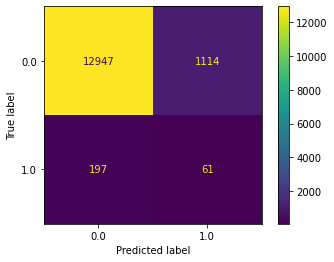

Accuracy:  90.84
F1-Score:  0.0851
Precision: 0.0519
Recall:    0.2364
MCC:       0.0762


In [ ]:
# Evaluate model
tempDF = get_model_metrics('KNN', knn)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

Tuned

In [ ]:
%%time
# Load libraries
from sklearn.neighbors import KNeighborsClassifier

# Create classification model
knn = KNeighborsClassifier(2, algorithm='ball_tree', leaf_size=3, weights='distance')

# Fit model
knn.fit(X_ou_smote, y_ou_smote)

CPU times: user 18 ms, sys: 900 µs, total: 18.9 ms
Wall time: 20.5 ms


[[12527  1534]
 [  183    75]]


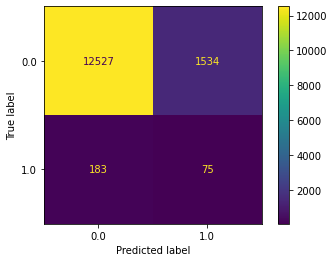

Accuracy:  88.01
F1-Score:  0.0803
Precision: 0.0466
Recall:    0.2907
MCC:       0.0765


In [ ]:
# Evaluate model
tempDF = get_model_metrics('KNN_tuned', knn)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Stochastic Gradient Descent

In [ ]:
%%time
# Load libraries
from sklearn.linear_model import SGDClassifier

# Create classification model
sgd = SGDClassifier(class_weight='balanced')

# Fit model
sgd.fit(X_ou_smote, y_ou_smote)

CPU times: user 67.9 ms, sys: 2.99 ms, total: 70.9 ms
Wall time: 69.8 ms


[[9506 4555]
 [  40  218]]


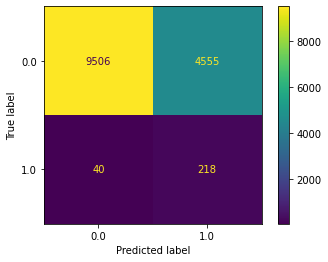

Accuracy:  67.91
F1-Score:  0.0867
Precision: 0.0457
Recall:    0.845
MCC:       0.147


In [ ]:
# Evaluate model
tempDF = get_model_metrics('SGD', sgd)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## LGBM Classifier

In [ ]:
%%time
# Load libraries
from lightgbm import LGBMClassifier

# Create classification model
lgbm = LGBMClassifier(class_weight='balanced')

# Fit model
lgbm.fit(X_ou_smote, y_ou_smote)

CPU times: user 385 ms, sys: 3.1 ms, total: 388 ms
Wall time: 400 ms


[[12528  1533]
 [  139   119]]


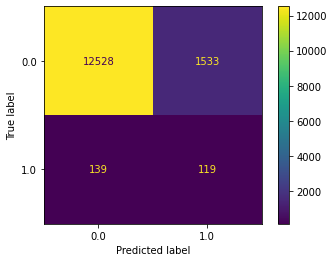

Accuracy:  88.32
F1-Score:  0.1246
Precision: 0.072
Recall:    0.4612
MCC:       0.1467


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LGBM', lgbm)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## XGBoost Classifier

In [ ]:
%%time
# Load libraries
from xgboost.sklearn import XGBClassifier

# Create classification model
xgbc = XGBClassifier(class_weight='balanced')

# Fit model
xgbc.fit(X_ou_smote, y_ou_smote)

CPU times: user 854 ms, sys: 4.87 ms, total: 859 ms
Wall time: 880 ms


[[12291  1770]
 [  117   141]]


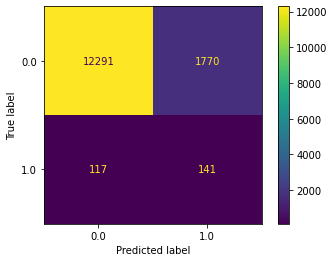

Accuracy:  86.82
F1-Score:  0.13
Precision: 0.0738
Recall:    0.5465
MCC:       0.1645


In [ ]:
# Evaluate model
tempDF = get_model_metrics('XGBC', xgbc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Linear Discriminant Analysis

In [ ]:
%%time
# Load libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create classification model
lda = LinearDiscriminantAnalysis()

# Fit model
lda.fit(X_ou_smote, y_ou_smote)

CPU times: user 32.8 ms, sys: 3.71 ms, total: 36.5 ms
Wall time: 51.5 ms


[[11688  2373]
 [   81   177]]


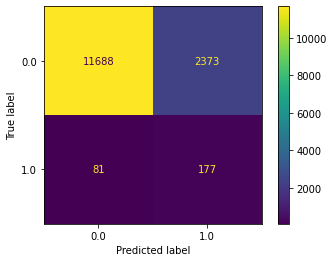

Accuracy:  82.86
F1-Score:  0.1261
Precision: 0.0694
Recall:    0.686
MCC:       0.1798


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LDA', lda)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Compare Model Performance

In [ ]:
# compare model metrics
model_compare.sort_values('MCC', ascending=False, ignore_index=True)

,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,LDA,82.86,0.1261,0.0694,0.6860,0.1798
1,MLP,84.34,0.1228,0.0683,0.6085,0.1653
2,LogReg,74.06,0.1011,0.0539,0.8101,0.1645
3,LogReg,74.06,0.1012,0.0539,0.8101,0.1645
4,XGBC,86.82,0.1300,0.0738,0.5465,0.1645
5,LinearSVC,73.11,0.0984,0.0523,0.8140,0.1610
6,AdaBoost,84.41,0.1178,0.0656,0.5775,0.1553
7,SVC,75.05,0.0984,0.0526,0.7558,0.1538
8,GBC,88.82,0.1285,0.0747,0.4574,0.1501
9,SGD,67.91,0.0867,0.0457,0.8450,0.1470


In [ ]:
# filter higher MCC and sort by Recall
table = model_compare.sort_values('MCC', ascending=False, ignore_index=True)
table[table['MCC'] > 0.15].sort_values('Recall', ascending=False)

,Model,Accuracy,F1_Score,Precision,Recall,MCC
5,LinearSVC,73.11,0.0984,0.0523,0.8140,0.1610
2,LogReg,74.06,0.1011,0.0539,0.8101,0.1645
3,LogReg,74.06,0.1012,0.0539,0.8101,0.1645
7,SVC,75.05,0.0984,0.0526,0.7558,0.1538
0,LDA,82.86,0.1261,0.0694,0.6860,0.1798
1,MLP,84.34,0.1228,0.0683,0.6085,0.1653
6,AdaBoost,84.41,0.1178,0.0656,0.5775,0.1553
4,XGBC,86.82,0.1300,0.0738,0.5465,0.1645
8,GBC,88.82,0.1285,0.0747,0.4574,0.1501


## Voting

In [ ]:
estimators=[('LinSVC', linSVC), ('LogReg', logit), ('SVC', svc), ('LDA', lda)]
            # ('SGD', sgd), ]#, 
            # , ('AdaBoost', adaboost)]
            # ('XGBC', xgbc), ('GBC', gbc)]
            #   ,  ('MLP', mlp), ('LGBM', lgbm) ]

In [ ]:
%%time
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(
    estimators=estimators,
    voting='hard'
)

eclf.fit(X_ou_smote, y_ou_smote)

CPU times: user 5.41 s, sys: 70.4 ms, total: 5.48 s
Wall time: 5.84 s


[[10856  3205]
 [   55   203]]


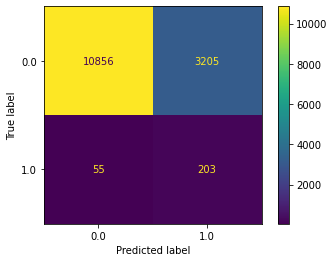

Accuracy:  77.23
F1-Score:  0.1107
Precision: 0.0596
Recall:    0.7868
MCC:       0.1746
CPU times: user 7.08 s, sys: 103 ms, total: 7.18 s
Wall time: 12.5 s


,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,Voting,77.23,0.1107,0.0596,0.7868,0.1746


In [ ]:
%%time
get_model_metrics('Voting', eclf)

## Stacking

In [ ]:
%%time
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

final_estimator = LogisticRegression(class_weight='balanced')
stk = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator
)

stk.fit(X_ou_smote, y_ou_smote)

CPU times: user 23 s, sys: 866 ms, total: 23.9 s
Wall time: 23.8 s


[[10899  3162]
 [   84   174]]


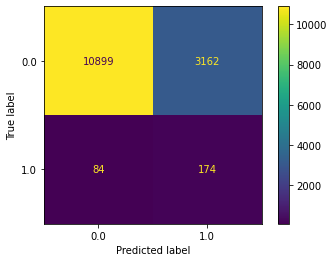

Accuracy:  77.33
F1-Score:  0.0968
Precision: 0.0522
Recall:    0.6744
MCC:       0.1415
CPU times: user 4.62 s, sys: 206 ms, total: 4.83 s
Wall time: 4.6 s


,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,Stacking,77.33,0.0968,0.0522,0.6744,0.1415


In [ ]:
%%time
get_model_metrics('Stacking', stk)

In [ ]:
len(X_smote)

57090

In [ ]:
y_smote.sum()

28545.0

In [ ]:
len(X_ou_smote)

8562

In [ ]:
y_ou_smote.sum()

2854.0

In [ ]:
len(X_over)

57090

In [ ]:
y_over.sum()

28545.0

In [ ]:
len(X_train)

29070

In [ ]:
y_train.sum()

525.0

In [ ]:
8562/29070

0.29453044375644993

In [ ]:
8562/57090

0.14997372569626904

# [Compare Classification Methods](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
Imbalanced

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score


# Set up DataFrame to store comparisons
model_compare = pd.DataFrame()

def get_model_metrics(name, model):
  '''Prints confusion matrix and some metrics; returns metrics in a DF'''
  cols = ['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall', 'MCC', 'AUC']
    # get predictions
  predictions = model.predict(X_test)
  
  # print confusion matrix
  cm = confusion_matrix(y_test, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=model.classes_)
  print(cm)
  disp.plot()
  plt.show()  
  
  # get accuracy, f1-score, precision, and recall
  # accuracy = round(model.score(X_test, y_test)*100, 2)
  cr = classification_report(y_test, predictions, output_dict=True)
  accuracy = round(cr['accuracy']*100, 2)
  print('Accuracy: ', accuracy)
  f1Score = round(cr['1.0']['f1-score'], 4)
  print('F1-Score: ', f1Score)
  precision = round(cr['1.0']['precision'], 4)
  print('Precision:', precision)
  recall = round(cr['1.0']['recall'], 4)
  print('Recall:   ', recall)
  MCC = round(matthews_corrcoef(y_test, predictions), 4)
  print('MCC:      ', MCC)
  AUC = round(roc_auc_score(y_test, predictions, average='weighted'), 4)
  print('AUC:      ', AUC)

  df = pd.DataFrame([[name, accuracy, f1Score, precision, recall, MCC, AUC]],
                    columns=cols)
  return df

## Random Forest

In [ ]:
%%time
# Load libraries
from sklearn.ensemble import RandomForestClassifier

# Create classifier
rfClass = RandomForestClassifier(class_weight='balanced')

# Train model
rfClass.fit(X_train, y_train)

CPU times: user 3.76 s, sys: 23.2 ms, total: 3.79 s
Wall time: 5.24 s


[[14056     5]
 [  258     0]]


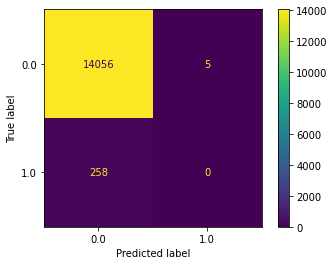

Accuracy:  98.16
F1-Score:  0.0
Precision: 0.0
Recall:    0.0
MCC:       -0.0025
AUC:       0.4998


In [ ]:
# Evaluate model
tempDF = get_model_metrics('RandomForest', rfClass)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Decision Tree

In [ ]:
%%time
# Load libraries
from sklearn.tree import DecisionTreeClassifier

# Create decision tree regressor object
decisiontree = DecisionTreeClassifier(class_weight='balanced')

# Train model
decisiontree.fit(X_train, y_train)

CPU times: user 165 ms, sys: 1.93 ms, total: 167 ms
Wall time: 231 ms


[[13827   234]
 [  238    20]]


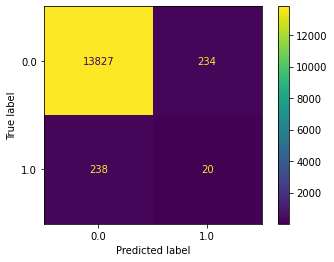

Accuracy:  96.7
F1-Score:  0.0781
Precision: 0.0787
Recall:    0.0775
MCC:       0.0613
AUC:       0.5304


In [ ]:
# Evaluate model
tempDF = get_model_metrics('DecisionTree', decisiontree)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Logistic Regression

In [ ]:
%%time
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create logistic regression
logit = LogisticRegression(class_weight='balanced')

# Train model
logit.fit(X_train, y_train)

CPU times: user 824 ms, sys: 516 ms, total: 1.34 s
Wall time: 1.49 s


[[10391  3670]
 [   48   210]]


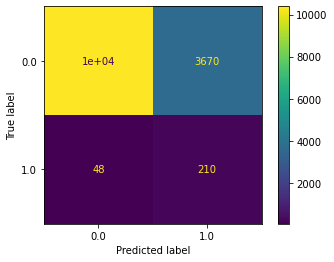

Accuracy:  74.03
F1-Score:  0.1015
Precision: 0.0541
Recall:    0.814
MCC:       0.1655
AUC:       0.7765


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LogReg_lbfgs', logit)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

In [ ]:
%%time
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create logistic regression
logit = LogisticRegression(class_weight='balanced',
                           solver='liblinear')

# Train model
logit.fit(X_train, y_train)

CPU times: user 515 ms, sys: 10.6 ms, total: 526 ms
Wall time: 692 ms


[[10391  3670]
 [   48   210]]


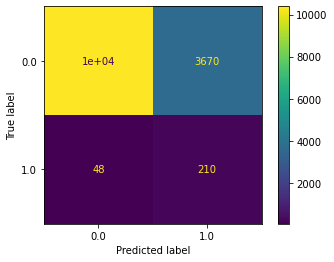

Accuracy:  74.03
F1-Score:  0.1015
Precision: 0.0541
Recall:    0.814
MCC:       0.1655
AUC:       0.7765


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LogReg_liblinear', logit)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Gaussian Naive Bayes Classifier

In [ ]:
%%time
# Load libraries
from sklearn.naive_bayes import GaussianNB

# Create Gaussian naive Bayes object
nBayes = GaussianNB()

# Fit model
nBayes.fit(X_train, y_train)

CPU times: user 19.3 ms, sys: 1.97 ms, total: 21.3 ms
Wall time: 43.8 ms


[[ 2966 11095]
 [    2   256]]


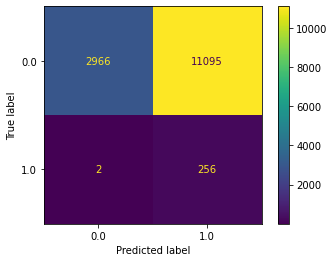

Accuracy:  22.5
F1-Score:  0.0441
Precision: 0.0226
Recall:    0.9922
MCC:       0.0667
AUC:       0.6016


In [ ]:
# Evaluate model
tempDF = get_model_metrics('GaussianNB', nBayes)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

In [ ]:
%%time
# Load libraries
from sklearn.naive_bayes import BernoulliNB

# Create Gaussian naive Bayes object
nBayes = BernoulliNB()

# Fit model
nBayes.fit(X_train, y_train)

CPU times: user 38.8 ms, sys: 4.81 ms, total: 43.6 ms
Wall time: 80.5 ms


[[13961   100]
 [  252     6]]


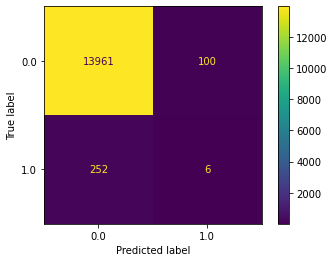

Accuracy:  97.54
F1-Score:  0.033
Precision: 0.0566
Recall:    0.0233
MCC:       0.0251
AUC:       0.5081


In [ ]:
# Evaluate model
tempDF = get_model_metrics('BernoulliNB', nBayes)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Support Vector Classifier (SVC)

In [ ]:
%%time
# Load libraries
from sklearn.svm import SVC

# Create classification model
svc = SVC(class_weight='balanced')

# Fit model
svc.fit(X_train, y_train)

CPU times: user 48.2 s, sys: 545 ms, total: 48.7 s
Wall time: 54.2 s


[[10656  3405]
 [   68   190]]


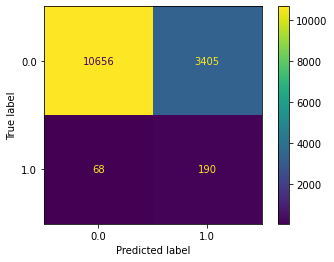

Accuracy:  75.75
F1-Score:  0.0986
Precision: 0.0529
Recall:    0.7364
MCC:       0.1516
AUC:       0.7471


In [ ]:
# Evaluate model
tempDF = get_model_metrics('SVC', svc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Linear SVC

In [ ]:
%%time
# Load libraries
from sklearn.svm import LinearSVC

# Create classification model
linSVC = LinearSVC(class_weight='balanced')

# Fit model
linSVC.fit(X_train, y_train)

CPU times: user 7.74 s, sys: 12 ms, total: 7.75 s
Wall time: 7.82 s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[[10640  3421]
 [   56   202]]


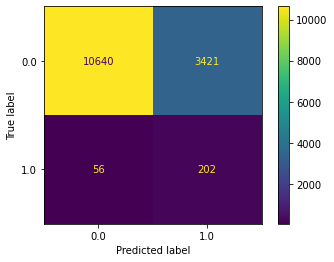

Accuracy:  75.72
F1-Score:  0.1041
Precision: 0.0558
Recall:    0.7829
MCC:       0.1651
AUC:       0.7698


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LinearSVC', linSVC)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Ada Boost Classifier

In [ ]:
%%time
# Load libraries
from sklearn.ensemble import AdaBoostClassifier

# Create classifier
adaboost = AdaBoostClassifier()

# Train model
adaboost.fit(X_train, y_train)

CPU times: user 1.36 s, sys: 6.83 ms, total: 1.36 s
Wall time: 1.39 s


[[14060     1]
 [  258     0]]


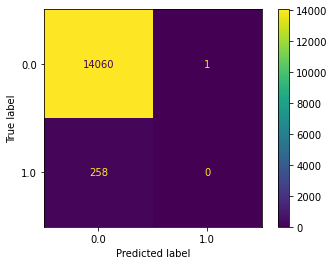

Accuracy:  98.19
F1-Score:  0.0
Precision: 0.0
Recall:    0.0
MCC:       -0.0011
AUC:       0.5


In [ ]:
# Evaluate model
tempDF = get_model_metrics('AdaBoost', adaboost)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## MLP Classifier

In [ ]:
%%time
# Load libraries
from sklearn.neural_network import MLPClassifier

# Create classification model
mlp = MLPClassifier(early_stopping=True)

# Fit model
mlp.fit(X_train, y_train)

CPU times: user 3.21 s, sys: 2.29 s, total: 5.5 s
Wall time: 2.98 s


[[14061     0]
 [  258     0]]


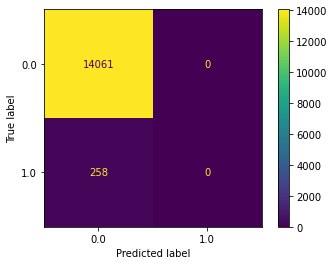

Accuracy:  98.2
F1-Score:  0.0
Precision: 0.0
Recall:    0.0
MCC:       0.0
AUC:       0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Evaluate model
tempDF = get_model_metrics('MLP', mlp)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Gradient Boosting Classifier

In [ ]:
%%time
# Load libraries
from sklearn.ensemble import GradientBoostingClassifier

# Create classification model
gbc = GradientBoostingClassifier()

# Fit model
gbc.fit(X_train, y_train)

CPU times: user 4.05 s, sys: 8.82 ms, total: 4.06 s
Wall time: 4.12 s


[[14054     7]
 [  258     0]]


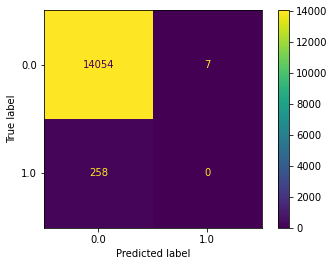

Accuracy:  98.15
F1-Score:  0.0
Precision: 0.0
Recall:    0.0
MCC:       -0.003
AUC:       0.4998


In [ ]:
# Evaluate model
tempDF = get_model_metrics('GBC', gbc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## K-Nearest Neighbor

In [ ]:
%%time
# Load libraries
from sklearn.neighbors import KNeighborsClassifier

# Create classification model
knn = KNeighborsClassifier(2)

# Fit model
knn.fit(X_train, y_train)

CPU times: user 6.92 ms, sys: 41 µs, total: 6.96 ms
Wall time: 6.44 ms


[[14046    15]
 [  257     1]]


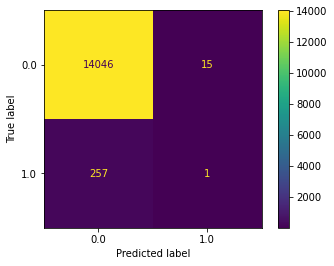

Accuracy:  98.1
F1-Score:  0.0073
Precision: 0.0625
Recall:    0.0039
MCC:       0.0112
AUC:       0.5014


In [ ]:
# Evaluate model
tempDF = get_model_metrics('KNN', knn)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Stochastic Gradient Descent

In [ ]:
%%time
# Load libraries
from sklearn.linear_model import SGDClassifier

# Create classification model
sgd = SGDClassifier(class_weight='balanced')

# Fit model
sgd.fit(X_train, y_train)

CPU times: user 301 ms, sys: 156 µs, total: 301 ms
Wall time: 304 ms


[[10888  3173]
 [   91   167]]


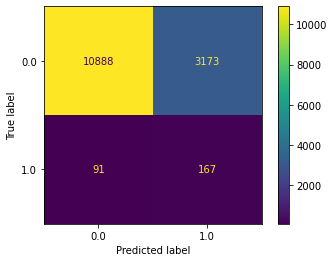

Accuracy:  77.21
F1-Score:  0.0928
Precision: 0.05
Recall:    0.6473
MCC:       0.1326
AUC:       0.7108


In [ ]:
# Evaluate model
tempDF = get_model_metrics('SGD', sgd)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## LGBM Classifier

In [ ]:
%%time
# Load libraries
from lightgbm import LGBMClassifier

# Create classification model
lgbm = LGBMClassifier(class_weight='balanced')

# Fit model
lgbm.fit(X_train, y_train)

CPU times: user 1.41 s, sys: 34.1 ms, total: 1.44 s
Wall time: 1.03 s


[[12363  1698]
 [  141   117]]


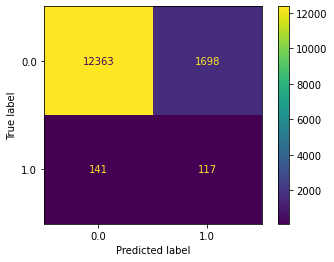

Accuracy:  87.16
F1-Score:  0.1129
Precision: 0.0645
Recall:    0.4535
MCC:       0.133
AUC:       0.6664


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LGBM', lgbm)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## XGBoost Classifier

In [ ]:
%%time
# Load libraries
from xgboost.sklearn import XGBClassifier

# Create classification model
xgbc = XGBClassifier(class_weight='balanced')

# Fit model
xgbc.fit(X_train, y_train)

CPU times: user 2.03 s, sys: 35.5 ms, total: 2.06 s
Wall time: 2.29 s


[[14061     0]
 [  258     0]]


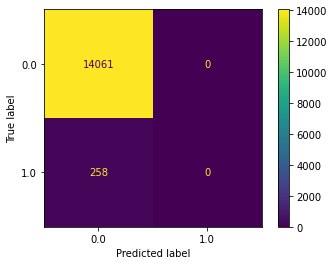

Accuracy:  98.2
F1-Score:  0.0
Precision: 0.0
Recall:    0.0
MCC:       0.0
AUC:       0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Evaluate model
tempDF = get_model_metrics('XGBC', xgbc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Linear Discriminant Analysis

In [ ]:
%%time
# Load libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create classification model
lda = LinearDiscriminantAnalysis()

# Fit model
lda.fit(X_train, y_train)

CPU times: user 98.6 ms, sys: 6.13 ms, total: 105 ms
Wall time: 120 ms


[[13895   166]
 [  236    22]]


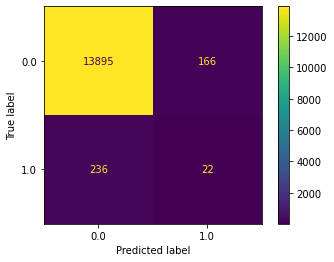

Accuracy:  97.19
F1-Score:  0.0987
Precision: 0.117
Recall:    0.0853
MCC:       0.0858
AUC:       0.5367


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LDA', lda)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Compare Model Performance

In [ ]:
# compare model metrics
model_compare.sort_values('MCC', ascending=False, ignore_index=True)

,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,LogReg,74.03,0.1015,0.0541,0.8140,0.1655,0.7765
1,LogReg,74.03,0.1015,0.0541,0.8140,0.1655,0.7765
2,LinearSVC,75.72,0.1041,0.0558,0.7829,0.1651,0.7698
3,SVC,75.75,0.0986,0.0529,0.7364,0.1516,0.7471
4,LGBM,87.16,0.1129,0.0645,0.4535,0.1330,0.6664
5,SGD,77.21,0.0928,0.0500,0.6473,0.1326,0.7108
6,LDA,97.19,0.0987,0.1170,0.0853,0.0858,0.5367
7,GaussianNB,22.50,0.0441,0.0226,0.9922,0.0667,0.6016
8,DecisionTree,96.70,0.0781,0.0787,0.0775,0.0613,0.5304
9,BernoulliNB,97.54,0.0330,0.0566,0.0233,0.0251,0.5081


In [ ]:
# filter higher MCC and sort by Recall
table = model_compare.sort_values('MCC', ascending=False, ignore_index=True)
table[table['MCC'] > 0.15].sort_values('Recall', ascending=False)

,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,LogReg,74.03,0.1015,0.0541,0.8140,0.1655,0.7765
1,LogReg,74.03,0.1015,0.0541,0.8140,0.1655,0.7765
2,LinearSVC,75.72,0.1041,0.0558,0.7829,0.1651,0.7698
3,SVC,75.75,0.0986,0.0529,0.7364,0.1516,0.7471


### [Voting Classifier](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)

In [ ]:
estimators=[('LogReg', logit), ('LinSVC', linSVC), ('SVC', svc)]
            # , ('LDA', lda)]
            # ('SGD', sgd), ]#, 
            # , ('AdaBoost', adaboost)]
            # ('XGBC', xgbc), ('GBC', gbc)]
            #   ,  ('MLP', mlp), ('LGBM', lgbm) ]

In [ ]:
%%time
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(
    estimators=estimators,
    voting='hard'
)

eclf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


CPU times: user 47.5 s, sys: 184 ms, total: 47.7 s
Wall time: 49.1 s


[[10558  3503]
 [   52   206]]


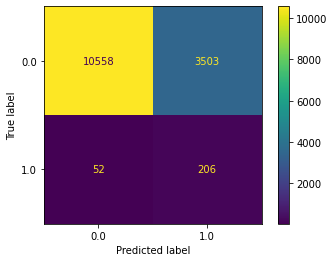

Accuracy:  75.17
F1-Score:  0.1039
Precision: 0.0555
Recall:    0.7984
MCC:       0.1668
AUC:       0.7747
CPU times: user 15.4 s, sys: 131 ms, total: 15.6 s
Wall time: 15.5 s


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,Voting,75.17,0.1039,0.0555,0.7984,0.1668,0.7747


In [ ]:
%%time
get_model_metrics('Voting', eclf)

#### Using Recall  metric:

In [ ]:
from sklearn.ensemble import VotingClassifier
# split the full train set into train and validation sets
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [ ]:
# get a list of base models
def get_models():
	models = list()
	models.append(('LogReg', logit))
	models.append(('LinSVC', linSVC))
	models.append(('SVC', svc))
	models.append(('SGD', sgd)) 
	models.append(('LGBM', lgbm)) 
	# models.append(('LDA', lda)) 
	models.append(('GNB', nBayes)) 
	# models.append(('DT', decisiontree)) 
	# models.append(('KNN', knn)) 
	# models.append(('MLP', mlp)) 
	# models.append(('XGBC', xgbc)) 
	# models.append(('AdaB', adaboost)) 
	# models.append(('RF', rfClass)) 
	# models.append(('GBC', gbc)) 
 
	return models

In [ ]:
from sklearn.metrics import recall_score

# evaluate each base model
def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		rec = recall_score(y_val, yhat)
		# store the performance
		scores.append(rec)
		# report model performance
	return scores

In [ ]:
%%time 
# create the base models
models = get_models()
# fit and evaluate each model
scores = evaluate_models(models, X_train_sub, X_val, y_train_sub, y_val)
print(scores)
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='hard', weights=scores)
# fit the ensemble on the training dataset
ensemble.fit(X_train, y_train)
# make predictions on test set
yhat = ensemble.predict(X_test)
# evaluate predictions
score = recall_score(y_test, yhat)
print('Weighted Recall: %.3f' % (score*100))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[0.837696335078534, 0.8167539267015707, 0.6858638743455497, 0.8900523560209425, 0.44502617801047123, 0.031413612565445025]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Weighted Recall: 78.295
CPU times: user 1min 37s, sys: 946 ms, total: 1min 38s
Wall time: 1min 56s


[[10712  3349]
 [   56   202]]


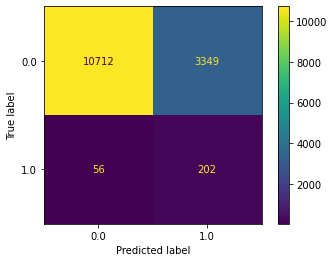

Accuracy:  76.22
F1-Score:  0.1061
Precision: 0.0569
Recall:    0.7829
MCC:       0.1678
AUC:       0.7724
CPU times: user 15.2 s, sys: 317 ms, total: 15.5 s
Wall time: 15.1 s


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,Ensemble_Recall,76.22,0.1061,0.0569,0.7829,0.1678,0.7724


In [ ]:
%%time
# Evaluate model
get_model_metrics('Ensemble_Recall', ensemble)

### Stacking

In [ ]:
%%time
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

final_estimator = LogisticRegression(class_weight='balanced')
stk = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator
)

stk.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

CPU times: user 4min 9s, sys: 1.7 s, total: 4min 10s
Wall time: 4min 24s


[[10298  3763]
 [   47   211]]


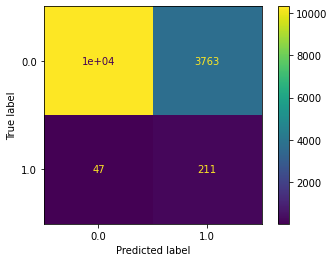

Accuracy:  73.39
F1-Score:  0.0997
Precision: 0.0531
Recall:    0.8178
MCC:       0.1634
AUC:       0.7751
CPU times: user 15.6 s, sys: 229 ms, total: 15.8 s
Wall time: 16.6 s


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,Stacking,73.39,0.0997,0.0531,0.8178,0.1634,0.7751


In [ ]:
%%time
get_model_metrics('Stacking', stk)

In [ ]:
len(X_smote)

57090

In [ ]:
y_smote.sum()

28545.0

In [ ]:
len(X_over)

57090

In [ ]:
y_over.sum()

28545.0

In [ ]:
len(X_train)

29070

In [ ]:
y_train.sum()

525.0

In [ ]:
8562/29070

0.29453044375644993

In [ ]:
8562/57090

0.14997372569626904

Verify Matthews Correlation Coefficient:

In [ ]:
predictions = logit.predict(X_test)

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_test, predictions)

0.16548431438278113

In [ ]:
cm
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

In [ ]:
from math import sqrt
MCC = ((TP*TN)-(FP*FN))/sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
MCC

0.1650688905923623

Verified!

try out a bagging classifier?

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

[[11202  2859]
 [   70   188]]


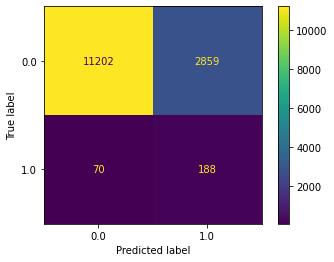

Accuracy:  79.54
F1-Score:  0.1138
Precision: 0.0617
Recall:    0.7287
MCC:       0.1707
AUC:       0.7627


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,LogReg_bag,79.54,0.1138,0.0617,0.7287,0.1707,0.7627


In [ ]:
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(base_estimator=ensemble, n_estimators=10, #logit
                        random_state=42).fit(X_train, y_train)

get_model_metrics('Ensemble_bag', clf)                    

## Hyperparameter Tuning

In [ ]:
# Load libraries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import matthews_corrcoef

In [ ]:
from sklearn.metrics import matthews_corrcoef, make_scorer
# # predictions = model.predict(X_test)
# # matthews_corrcoef(y_test, predictions)
# grid = GridSearchCV(model, parameter_space, scoring=matthews_corrcoef, cv=5)
mcc = make_scorer(matthews_corrcoef)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create classifier
logit = LogisticRegression(class_weight='balanced',
                           random_state=42, max_iter=500)

# Get a baseline model
baseline = logit.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['none', 'l2', 'l1'],# 'elasticnet'],
    'tol': [1e-7, 1e-6, 1e-4],# 1e-3], 1e-5
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'sag', 'saga']#,'newton-cg', 'lbfgs']
    # 'l1_ratio': [0.5]
}
grid = GridSearchCV(logit, parameter_space, scoring=mcc, cv=5)
# grid = RandomizedSearchCV(logit, parameter_space, cv=5, n_iter=30, random_state=42)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ig

CPU times: user 40min 48s, sys: 34 s, total: 41min 22s
Wall time: 40min 39s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solve

In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1e-07} 

Baseline Accuracy:	74.03
Tuned Accuracy:		16.53


In [ ]:
%%time
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create logistic regression
logit = LogisticRegression(class_weight='balanced',
                           C=0.1, penalty='l2', solver='liblinear', tol=1e-7,
                           random_state=42, max_iter=500)
# Train model
logit.fit(X_train, y_train)

CPU times: user 273 ms, sys: 4.97 ms, total: 278 ms
Wall time: 629 ms


[[10387  3674]
 [   48   210]]


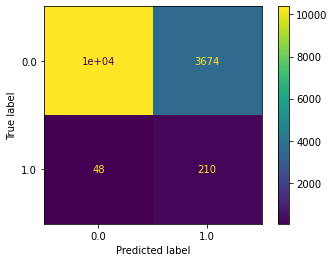

Accuracy:  74.01
F1-Score:  0.1014
Precision: 0.0541
Recall:    0.814
MCC:       0.1653


,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,LogReg,74.01,0.1014,0.0541,0.814,0.1653


In [ ]:
# Evaluate model
get_model_metrics('LogReg', logit)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create classifier
logit = LogisticRegression(class_weight='balanced',
                           random_state=42, max_iter=500)

# Get a baseline model
baseline = logit.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['elasticnet'],#'none', 'l2', 'l1', 
    'tol': [1e-7, 1e-6, 1e-4],# 1e-3], 1e-5
    'C': [0.1, 1, 10],
    'solver': ['saga'],#'liblinear', 'sag']#,'newton-cg', 'lbfgs']
    'l1_ratio': [0.3, 0.5, 0.7]
}
grid = GridSearchCV(logit, parameter_space, scoring=mcc, cv=5)
# grid = RandomizedSearchCV(logit, parameter_space, cv=5, n_iter=30, random_state=42)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

CPU times: user 10min 4s, sys: 14.2 s, total: 10min 18s
Wall time: 10min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga', 'tol': 1e-07} 

Baseline Accuracy:	74.03
Tuned Accuracy:		15.71


In [ ]:
%%time
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create logistic regression
logit = LogisticRegression(class_weight='balanced',
                           penalty='elasticnet', solver='saga', 
                           tol=1e-7, l1_ratio=0.5,
                           random_state=42, max_iter=500)
# Train model
logit.fit(X_train, y_train)

CPU times: user 5.68 s, sys: 8.97 ms, total: 5.69 s
Wall time: 5.68 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[[10900  3161]
 [   71   187]]


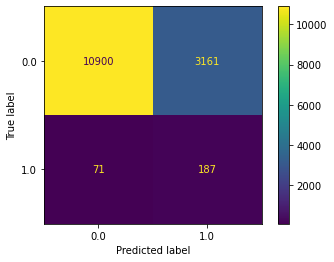

Accuracy:  77.43
F1-Score:  0.1037
Precision: 0.0559
Recall:    0.7248
MCC:       0.1571


,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,LogReg,77.43,0.1037,0.0559,0.7248,0.1571


In [ ]:
# Evaluate model
get_model_metrics('LogReg', logit)

### Linear SVC

In [ ]:
from sklearn.svm import LinearSVC

# Create classifier
linSVC = LinearSVC(class_weight='balanced',
                   max_iter=2000,
                   random_state=42)

# Get a baseline model
baseline = linSVC.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['l2', 'l1'],
    'loss': ['squared_hinge'],#'hinge', 
    'dual': [True, False],
    'tol': [1e-8, 1e-6, 1e-4],# 1e-3], 1e-5, 1e-7
    'C': [1, 10, 100]# 0.1, 
}
grid = GridSearchCV(linSVC, parameter_space, scoring=mcc, cv=5)
# grid = RandomizedSearchCV(logit, parameter_space, cv=5, n_iter=30, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

CPU times: user 6min 35s, sys: 14.5 s, total: 6min 50s
Wall time: 6min 33s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 10, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 1e-08} 

Baseline Accuracy:	73.55
Tuned Accuracy:		16.36


In [ ]:
%%time
# Load libraries
from sklearn.svm import LinearSVC

# Create classification model
linSVC = LinearSVC(class_weight='balanced',
                   C=10, dual=False, loss='squared_hinge', 
                   penalty='l2', tol=1e-8)

# Fit model
linSVC.fit(X_train, y_train)

CPU times: user 267 ms, sys: 3.98 ms, total: 271 ms
Wall time: 270 ms


[[10269  3792]
 [   46   212]]


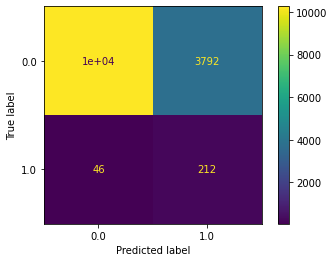

Accuracy:  73.2
F1-Score:  0.0995
Precision: 0.0529
Recall:    0.8217
MCC:       0.1636


,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,LinSVC,73.2,0.0995,0.0529,0.8217,0.1636


In [ ]:
# Evaluate model
get_model_metrics('LinSVC', linSVC)

### Support Vector Classifier (SVC)

In [ ]:
from sklearn.svm import SVC

# Create classifier
svc = SVC(class_weight='balanced',
          random_state=42)

# Get a baseline model
baseline = svc.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'kernel': ['linear'],# 'poly', 'rbf', 'sigmoid'], # follow up w/other params
    'C': [1, 10, 100], #0.1,
    # 'gamma': ['scale', 'auto'],
    # 'shrinking': [True, False],
    # 'probability': [True, False],
    'tol': [1e-4, 1e-3, 1e-2]
}
grid = GridSearchCV(svc, parameter_space, scoring=mcc, cv=5)
# grid = RandomizedSearchCV(logit, parameter_space, cv=5, n_iter=30, random_state=42)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

CPU times: user 29min 17s, sys: 3.83 s, total: 29min 20s
Wall time: 30min 6s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 100, 'kernel': 'linear', 'tol': 0.01} 

Baseline Accuracy:	75.75
Tuned Accuracy:		16.17


In [ ]:
%%time
# Load libraries
from sklearn.svm import SVC

# Create classification model
svc = SVC(class_weight='balanced',
          kernel='linear', C=100, tol=0.01,
          random_state=42)

# Fit model
svc.fit(X_train, y_train)

CPU times: user 1min 54s, sys: 251 ms, total: 1min 54s
Wall time: 1min 58s


[[10213  3848]
 [   46   212]]


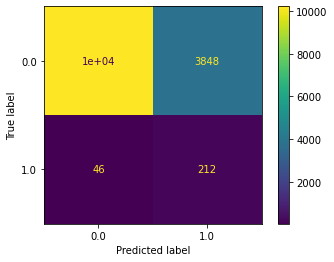

Accuracy:  72.81
F1-Score:  0.0982
Precision: 0.0522
Recall:    0.8217
MCC:       0.1617


,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,SVC,72.81,0.0982,0.0522,0.8217,0.1617


In [ ]:
# Evaluate model
get_model_metrics('SVC', svc)

### Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier

# Create classifier
sgd = SGDClassifier(class_weight='balanced',
                    max_iter=2000,
                    early_stopping=True,
                    random_state=42)

# Get a baseline model
baseline = sgd.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'loss': ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge',
             'perceptron', 'squared_error', 'huber', 'epsilon_insensitive',
             'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1'],
    'alpha': [1e-5, 1e-4, 1e-3],
    'tol': [1e-9, 1e-8, 1e-7],#, 1e-3, 1e-6
    'epsilon': [0.0001, 0.001, 0.01],# , 1, 0.1
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}
grid = GridSearchCV(sgd, parameter_space, scoring=mcc, cv=5)
# grid = RandomizedSearchCV(logit, parameter_space, cv=5, n_iter=30, random_state=42)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

CPU times: user 4min 7s, sys: 2min 52s, total: 6min 59s
Wall time: 3min 47s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
8370 fits failed out of a total of 10800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 892, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 649, in _fit
    self._validate_params()
  File "/usr/local/lib/pyth

In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'alpha': 0.0001, 'epsilon': 0.01, 'learning_rate': 'optimal', 'loss': 'huber', 'penalty': 'l2', 'tol': 1e-09} 

Baseline Accuracy:	80.45
Tuned Accuracy:		15.3


In [ ]:
%%time
# Load libraries
from sklearn.linear_model import SGDClassifier

# Create classification model
sgd = SGDClassifier(class_weight='balanced',
                    alpha=0.0001, epsilon=0.01, learning_rate='optimal',
                    loss='huber', penalty='l2', tol=1e-9,
                    max_iter=2000,
                    early_stopping=True,
                    random_state=42)

# Fit model
sgd.fit(X_train, y_train)

CPU times: user 99.7 ms, sys: 50 ms, total: 150 ms
Wall time: 88.3 ms


[[9527 4534]
 [  35  223]]


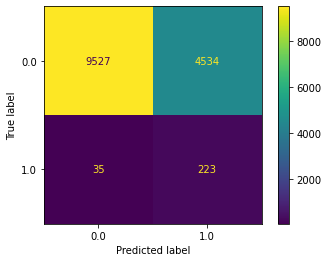

Accuracy:  68.09
F1-Score:  0.0889
Precision: 0.0469
Recall:    0.8643
MCC:       0.153


,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,SGD,68.09,0.0889,0.0469,0.8643,0.153


In [ ]:
# Evaluate model
get_model_metrics('SGD', sgd)

## Hyperparameter tuning, multiple metrics

In [ ]:
# Load libraries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer

mcc = make_scorer(matthews_corrcoef)
scoring = {'MCC': mcc, 'Recall': 'recall', 'AUC': roc_auc(average='weighted')}#'roc_auc'}

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create classifier
logit = LogisticRegression(class_weight='balanced',
                           random_state=42, max_iter=500)

# Get a baseline model
baseline = logit.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['none', 'l2', 'l1'],
    'tol': [1e-7, 1e-5, 1e-3],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'sag', 'saga']
}
# grid = GridSearchCV(logit, parameter_space, scoring=scoring, cv=5)
# grid = RandomizedSearchCV(logit, parameter_space, cv=5, n_iter=30, random_state=42)
grid = GridSearchCV(logit, parameter_space, scoring=scoring, cv=5,
                    refit='MCC', return_train_score=True)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ig

CPU times: user 48min 17s, sys: 49.6 s, total: 49min 7s
Wall time: 48min 5s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1e-07} 

Baseline Accuracy:	74.03
Tuned Accuracy:		16.53


In [ ]:
%%time
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create logistic regression
logit = LogisticRegression(class_weight='balanced',
                           penalty='l2', solver='liblinear', 
                           tol=1e-7, C=0.1,
                           random_state=42, max_iter=500)
# Train model
logit.fit(X_train, y_train)

CPU times: user 321 ms, sys: 860 µs, total: 322 ms
Wall time: 360 ms


[[10387  3674]
 [   48   210]]


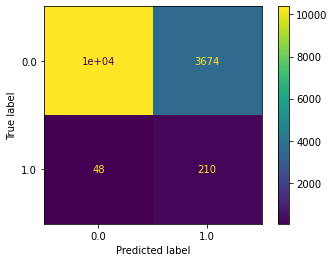

Accuracy:  74.01
F1-Score:  0.1014
Precision: 0.0541
Recall:    0.814
MCC:       0.1653


,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,LogReg,74.01,0.1014,0.0541,0.814,0.1653


In [ ]:
# Evaluate model
get_model_metrics('LogReg', logit)

### Linear SVC

In [ ]:
from sklearn.svm import LinearSVC

# Create classifier
linSVC = LinearSVC(class_weight='balanced',
                   max_iter=2000,
                   random_state=42)

# Get a baseline model
baseline = linSVC.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['l2', 'l1'],
    'loss': ['squared_hinge'],#'hinge', 
    'dual': [True, False],
    'tol': [1e-7, 1e-5, 1e-4],
    'C': [1, 10, 100]
}
# grid = GridSearchCV(linSVC, parameter_space, scoring=scoring, cv=5)
# grid = RandomizedSearchCV(logit, parameter_space, cv=5, n_iter=30, random_state=42)
grid = GridSearchCV(linSVC, parameter_space, scoring=scoring, cv=5,
                    refit='MCC', return_train_score=True)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

CPU times: user 10min 40s, sys: 20.3 s, total: 11min
Wall time: 10min 43s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 10, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 1e-07} 

Baseline Accuracy:	73.55
Tuned Accuracy:		16.36


In [ ]:
results = grid.cv_results_

In [ ]:
%%time
# Load libraries
from sklearn.svm import LinearSVC

# Create classification model
linSVC = LinearSVC(class_weight='balanced',
                   C=10, dual=False, loss='squared_hinge', 
                   penalty='l2', tol=1e-7)

# Fit model
linSVC.fit(X_train, y_train)

CPU times: user 238 ms, sys: 850 µs, total: 239 ms
Wall time: 239 ms


[[10269  3792]
 [   46   212]]


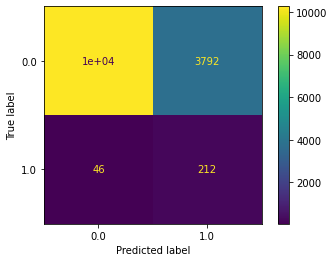

Accuracy:  73.2
F1-Score:  0.0995
Precision: 0.0529
Recall:    0.8217
MCC:       0.1636


,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,LinSVC,73.2,0.0995,0.0529,0.8217,0.1636


In [ ]:
# Evaluate model
get_model_metrics('LinSVC', linSVC)

### Support Vector Classifier (SVC)

In [ ]:
from sklearn.svm import SVC

# Create classifier
svc = SVC(class_weight='balanced',
          random_state=42)

# Get a baseline model
baseline = svc.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'kernel': ['linear']#, 'poly', 'rbf', 'sigmoid'] # follow up w/other params
    'C': [10, 100, 1000], #0.1, 1
    # 'gamma': ['scale', 'auto'],
    # 'shrinking': [True, False],
    # 'probability': [True, False],
    'tol': [1e-4, 1e-3, 0.01, 0.1]
}
# grid = GridSearchCV(svc, parameter_space, scoring=mcc, cv=5)
# grid = RandomizedSearchCV(logit, parameter_space, cv=5, n_iter=30, random_state=42)
grid = GridSearchCV(svc, parameter_space, scoring=scoring, cv=5,
                    refit='MCC', return_train_score=True)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

CPU times: user 20min 27s, sys: 2.7 s, total: 20min 30s
Wall time: 21min 28s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'kernel': 'linear'} 

Baseline Accuracy:	75.75
Tuned Accuracy:		16.29


In [ ]:
%%time
# Load libraries
from sklearn.svm import SVC

# Create classification model
svc = SVC(class_weight='balanced',
          kernel='linear', C=100, tol=0.01,
          random_state=42)

# Fit model
svc.fit(X_train, y_train)

CPU times: user 1min 56s, sys: 190 ms, total: 1min 57s
Wall time: 1min 56s


[[10213  3848]
 [   46   212]]


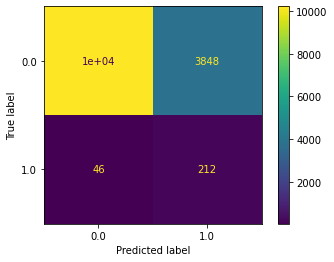

Accuracy:  72.81
F1-Score:  0.0982
Precision: 0.0522
Recall:    0.8217
MCC:       0.1617


,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,SVC,72.81,0.0982,0.0522,0.8217,0.1617


In [ ]:
# Evaluate model
get_model_metrics('SVC', svc)

### Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier

# Create classifier
sgd = SGDClassifier(class_weight='balanced',
                    max_iter=2000,
                    early_stopping=True,
                    random_state=42)

# Get a baseline model
baseline = sgd.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'loss': ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge',
             'perceptron', 'squared_error', 'huber', 'epsilon_insensitive',
             'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1'],
    'alpha': [1e-5, 1e-4, 1e-3],
    'tol': [1e-7, 1e-5, 1e-3],
    'epsilon': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}
# grid = GridSearchCV(sgd, parameter_space, scoring=mcc, cv=5)
# grid = RandomizedSearchCV(logit, parameter_space, cv=5, n_iter=30, random_state=42)
grid = GridSearchCV(sgd, parameter_space, scoring=scoring, cv=5,
                    refit='MCC', return_train_score=True)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

CPU times: user 8min 22s, sys: 5min 59s, total: 14min 21s
Wall time: 7min 40s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
8370 fits failed out of a total of 10800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 892, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 649, in _fit
    self._validate_params()
  File "/usr/local/lib/pyth

In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'alpha': 0.0001, 'epsilon': 0.01, 'learning_rate': 'optimal', 'loss': 'huber', 'penalty': 'l2', 'tol': 1e-07} 

Baseline Accuracy:	80.45
Tuned Accuracy:		15.3


In [ ]:
%%time
# Load libraries
from sklearn.linear_model import SGDClassifier

# Create classification model
sgd = SGDClassifier(class_weight='balanced',
                    alpha=0.0001, epsilon=0.01, learning_rate='optimal',
                    loss='huber', penalty='l2', tol=1e-7,
                    max_iter=2000,
                    early_stopping=True,
                    random_state=42)

# Fit model
sgd.fit(X_train, y_train)

CPU times: user 174 ms, sys: 97.3 ms, total: 271 ms
Wall time: 157 ms


[[9527 4534]
 [  35  223]]


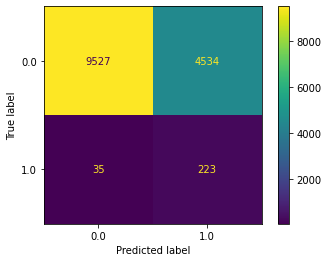

Accuracy:  68.09
F1-Score:  0.0889
Precision: 0.0469
Recall:    0.8643
MCC:       0.153


,Model,Accuracy,F1_Score,Precision,Recall,MCC
0,SGD,68.09,0.0889,0.0469,0.8643,0.153


In [ ]:
# Evaluate model
get_model_metrics('SGD', sgd)

## [Voting](https://machinelearningmastery.com/weighted-average-ensemble-with-python/)

In [ ]:
from sklearn.ensemble import VotingClassifier
# split the full train set into train and validation sets
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [ ]:
# get a list of base models
def get_models():
	models = list()
	models.append(('LogReg', logit))
	models.append(('LinSVC', linSVC))
	models.append(('SVC', svc))
	models.append(('SGD', sgd)) 
	return models

#### Using AUC metric:

In [ ]:
from sklearn.metrics import roc_auc_score

# evaluate each base model
def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		auc = roc_auc_score(y_val, yhat, average='weighted')
		# store the performance
		scores.append(auc)
		# report model performance
	return scores

In [ ]:
%%time 
# create the base models
models = get_models()
# fit and evaluate each model
scores = evaluate_models(models, X_train_sub, X_val, y_train_sub, y_val)
print(scores)
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='hard', weights=scores)
# fit the ensemble on the training dataset
ensemble.fit(X_train, y_train)
# make predictions on test set
yhat = ensemble.predict(X_test)
# evaluate predictions
score = roc_auc_score(y_test, yhat, average='weighted')
print('Weighted AUC: %.3f' % (score*100))

[0.7770317259780631, 0.7819073560682706, 0.7897198343182219, 0.7731051636076935]
Weighted AUC: 77.462
CPU times: user 3min 54s, sys: 1 s, total: 3min 55s
Wall time: 4min 12s


[[10230  3831]
 [   46   212]]


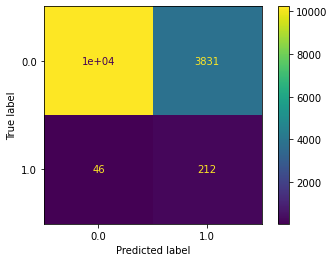

Accuracy:  72.92
F1-Score:  0.0986
Precision: 0.0524
Recall:    0.8217
MCC:       0.1623
AUC:       0.7746
CPU times: user 6.05 s, sys: 232 ms, total: 6.28 s
Wall time: 6.14 s


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,Ensemble,72.92,0.0986,0.0524,0.8217,0.1623,0.7746


In [ ]:
%%time
# Evaluate model
get_model_metrics('Ensemble_AUC', ensemble)

### Using Recall  metric:

In [ ]:
from sklearn.metrics import recall_score

# evaluate each base model
def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		rec = recall_score(y_val, yhat)
		# store the performance
		scores.append(rec)
		# report model performance
	return scores

In [ ]:
%%time 
# create the base models
models = get_models()
# fit and evaluate each model
scores = evaluate_models(models, X_train_sub, X_val, y_train_sub, y_val)
print(scores)
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='hard', weights=scores)
# fit the ensemble on the training dataset
ensemble.fit(X_train, y_train)
# make predictions on test set
yhat = ensemble.predict(X_test)
# evaluate predictions
score = recall_score(y_test, yhat)
print('Weighted Recall: %.3f' % (score*100))

[0.837696335078534, 0.8534031413612565, 0.8743455497382199, 0.7958115183246073]
Weighted Recall: 82.171
CPU times: user 3min 54s, sys: 961 ms, total: 3min 55s
Wall time: 4min 11s


[[10290  3771]
 [   46   212]]


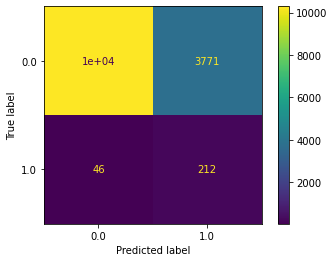

Accuracy:  73.34
F1-Score:  0.1
Precision: 0.0532
Recall:    0.8217
MCC:       0.1643
AUC:       0.7768
CPU times: user 5.75 s, sys: 237 ms, total: 5.99 s
Wall time: 5.74 s


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,Ensemble_Recall,73.34,0.1,0.0532,0.8217,0.1643,0.7768


In [ ]:
%%time
# Evaluate model
get_model_metrics('Ensemble_Recall', ensemble)

### Using Matthews Correlation Coefficient metric:

In [ ]:
from sklearn.metrics import matthews_corrcoef

# evaluate each base model
def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		mcc = matthews_corrcoef(y_val, yhat)
		# store the performance
		scores.append(mcc)
		# report model performance
	return scores

In [ ]:
%%time 
# create the base models
models = get_models()
# fit and evaluate each model
scores = evaluate_models(models, X_train_sub, X_val, y_train_sub, y_val)
print(scores)
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='hard', weights=scores)
# fit the ensemble on the training dataset
ensemble.fit(X_train, y_train)
# make predictions on test set
yhat = ensemble.predict(X_test)
# evaluate predictions
score = matthews_corrcoef(y_test, yhat)
print('Weighted MCC: %.3f' % (score*100))

[0.16976509962266212, 0.17172819907162, 0.17556707027792468, 0.17384030721868218]
Weighted MCC: 16.177
CPU times: user 3min 8s, sys: 919 ms, total: 3min 9s
Wall time: 3min 8s


[[10214  3847]
 [   46   212]]


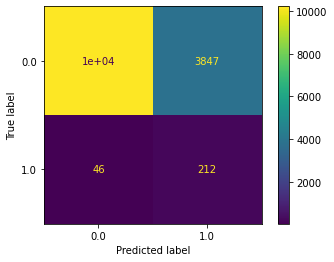

Accuracy:  72.81
F1-Score:  0.0982
Precision: 0.0522
Recall:    0.8217
MCC:       0.1618
AUC:       0.7741
CPU times: user 6.29 s, sys: 141 ms, total: 6.43 s
Wall time: 6.34 s


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,Ensemble_MCC,72.81,0.0982,0.0522,0.8217,0.1618,0.7741


In [ ]:
%%time
# Evaluate model
get_model_metrics('Ensemble_MCC', ensemble)